# Stage 3: Implementing a RAG System for Question Answering
### Team 7: Nicole Bolliger, Vitalia Vedenikova


# Generate and Categorize Q&A Pairs

## 1. Preparation Steps

### 1.1. Requirements

In [ ]:
%%writefile requirements.txt

chromadb==0.5.0
datasets==2.19.1
gdown==5.2.0
kaggle==1.6.1
langchain==0.3.10
langchain-community==0.3.10
langchain-experimental==0.3.3
langchain-openai==0.2.12
langdetect==1.0.9
lorem-text==2.1
nbformat>=4.2.0
openai==1.57.1
plotly==5.22.0
pretty-jupyter==1.0
ragas==0.1.8
seaborn==0.13.2
sentence-transformers==3.0.0
spacy>=3.7
textstat==0.7.3
umap-learn==0.5.5
unidecode
langdetect
keybert

Writing requirements.txt


In [ ]:
%pip install torch==2.5.1 --quiet --index-url https://download.pytorch.org/whl/cu121
!pip install textwrap --quiet

ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap


In [ ]:
%pip install -r ./requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
import json
import os
import warnings
import zipfile
from collections import Counter
from pathlib import Path
from typing import Dict, List

from langdetect import detect, detect_langs, DetectorFactory
import re
from bs4 import BeautifulSoup
import unidecode
from keybert import KeyBERT

import chromadb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import torch
from chromadb import Collection, Documents, EmbeddingFunction, Embeddings
from datasets import Dataset
from dotenv import load_dotenv
from langdetect import detect
from lorem_text import lorem
from ragas import RunConfig, evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_relevancy, answer_correctness)
from spacy.lang.en import English
from textstat import flesch_reading_ease
from tqdm import tqdm
import umap
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import textwrap
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from langchain.chains.base import Chain
from langchain.text_splitter import RecursiveCharacterTextSplitter, TextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma, VectorStore
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.language_models import LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv()
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/ragas/metrics/__init__.py:1: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from ragas.metrics._answer_correctness import AnswerCorrectness, answer_correctness
/usr/local/li

In [ ]:
%%writefile .env

#OPENAI_API_KEY=ENTER_HERE
OPENAI_API_KEY = sk-proj-...

Writing .env


In [ ]:
# Loading environment variables from .env file
load_dotenv()

# Accessing the API key
api_key = os.getenv("OPENAI_API_KEY")

# Initializing the language model
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Defining a question prompt template
question_prompt = ChatPromptTemplate.from_template(
    "Answer the following question: {question}")
question_chain = question_prompt | llm | StrOutputParser()
question_chain.invoke({"question": "What is the meaning of life?"})

"The meaning of life is a deeply philosophical question that has been debated for centuries. It ultimately depends on an individual's beliefs, values, and perspectives. Some may find meaning in personal relationships, accomplishments, spiritual beliefs, or simply in the pursuit of happiness and fulfillment. Ultimately, the meaning of life is subjective and can vary greatly from person to person."

### 1.2. Datasets

#### 1.2.1. Loading the datasets

We have three datasets available for developing our RAG system :
- A dataset containing media texts covering various aspects of cleantech, from renewable energy and eco-friendly materials to carbon reduction strategies.
- A dataset consisting of green technology patents with records from 2022 to 2024
- A small, high-quality evaluation dataset for the "Retrieval" step in Retrieval-Augmented Generation (specifically designed for the media dataset)

In [ ]:
## Mount the google drive and check that the datasets are there
from google.colab import drive
drive.mount('/content/drive')
!pwd
!ls '/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/'

Mounted at /content/drive
/content
chunk_keywords.json			      media_train.csv
chunks_folder				      media_train_sentence.csv
CleanTech_22-24_updated.json		      media_train_sentence_ORIGINAL.csv
cleantech_media_dataset_v3_2024-10-28.csv     media_val_sentence.csv
cleantech_rag_evaluation_data_2024-09-20.csv  patent_df.csv
df_media_v2.csv				      patent_test.csv
df_patent_v2.csv			      patent_test_sentence.csv
distilbert_model			      patent_test_sentence_ORIGINAL.csv
distilbert_similarity_model.pth		      patent_train.csv
doc2vec_media_model_dm.model		      patent_train_sentence.csv
doc2vec_media_model.model		      patent_train_sentence_ORIGINAL.csv
doc2vec_patent_model_dm.model		      patent_val_sentence.csv
doc2vec_patent_model.model		      RG65.csv
eval_df.csv				      sample_df.csv
glove.6B.zip				      S_BERT.model
media_df.csv				      S_BERT_patent.model
media_test.csv				      selected_chunks_patent_df.csv
media_test_sentence.csv			      sts-train.csv
media_test_sentence_OR

In [ ]:
## Load the patent dataset

#Import csv data into dataframes
patent_json = []  # Initialize patent_json outside the try-except block

file_path = '/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/CleanTech_22-24_updated.json'

with open(file_path) as f:
    try:
        # Try loading the entire file as a single JSON object
        patent_json = json.load(f)
    except json.JSONDecodeError:
        # If loading as a single JSON object fails
        f.seek(0)  # Reset the file pointer to the beginning

        # Iterate through each line in the file
        for line in f:
            try:
                # Attempt to parse each line as a JSON object
                data = json.loads(line)
                # Append the parsed JSON object to patent_json list
                patent_json.append(data)
            except json.JSONDecodeError as e:
                # If a line is not valid JSON, print an error message
                print(f"Skipping invalid line: {line.strip()} - Error: {e}")

# Convert dictionary to JSON string
json_string = json.dumps(patent_json)

# Convert nested JSON data to Pandas DataFrame
patent_df = pd.read_json(json_string, orient='records')
patent_df.head(3)

,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code
0,CN-117138249-A,CN-202311356270-A,CN,一种石墨烯光疗面罩,The application provides a graphene photothera...,20231201,"[LI HAITAO, CAO WENQIANG]",A61N2005/0654
1,CN-117151396-A,CN-202311109834-A,CN,Distributed economic scheduling method for win...,The invention discloses a distributed economic...,20231201,"[HU PENGFEI, LI ZIMENG]",G06Q50/06
2,CN-117141530-A,CN-202310980795-A,CN,氢能源动力轨道车辆组,The invention discloses a hydrogen energy powe...,20231201,"[XIE BO, ZHANG SHUIQING, ZHOU FEI, LIU YONG, Z...",Y02T90/40


In [ ]:
## Load the media dataset

media_df = pd.read_csv('drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/cleantech_media_dataset_v3_2024-10-28.csv')
media_df.head(3)

Unnamed: 0  \
0       93320   
1       93321   
2       98159   

                                                                                 title  \
0                                            XPeng Delivered ~100,000 Vehicles In 2021   
1                                        Green Hydrogen: Drop In Bucket Or Big Splash?   
2  World’ s largest floating PV plant goes online in China – pv magazine International   

         date  author  \
0  2022-01-02     NaN   
1  2022-01-02     NaN   
2  2022-01-03     NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
## Load the evaluation dataset
eval_df = pd.read_csv('drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/cleantech_rag_evaluation_data_2024-09-20.csv', delimiter=';', encoding='utf-8', index_col=0)
eval_df.head(3)

,question_id,question,relevant_text,answer,article_url
example_id,,,,,
1,1,What is the innovation behind Leclanché's new method to produce lithium-ion batteries?,"Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) batteries. It has replaced highly toxic organic solvents, commonly used in the production process, with a water-based process to make nickel-manganese-cobalt-aluminium cathodes (NMCA).",Leclanché's innovation is using a water-based process instead of highly toxic organic solvents to produce nickel-manganese-cobalt-aluminium cathodes for lithium-ion batteries.,https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energy-density/
2,2,What is the EU’s Green Deal Industrial Plan?,"The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive and to accelerate its transition to net zero. It intends to support the expansion of European manufacturing of technologies, goods and services needed to achieve its climate targets.","The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/
3,2,What is the EU’s Green Deal Industrial Plan?,"The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment that is conducive to increasing the European Union's manufacturing capacity of “net-zero” technologies, to improve the competitiveness of European industry.","The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",https://www.pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan/


#### 1.2.2. Cleaning the datasets

As seen in stages 1 and 2, clean content gives the best quality embeddings for words and sentences alike. Therefore, we repeat the same steps for sentence embeddings as in stage 2, particularily focusing on removing data srcaping artifacts. It is to be noted that while removing all artifacts could offer further refinement, it also presents a significant challenge and so we note their presence without removing them completely.

##### Media Dataset

In [ ]:
media_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20111 entries, 0 to 20110
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20111 non-null  int64  
 1   title       20111 non-null  object 
 2   date        20111 non-null  object 
 3   author      0 non-null      float64
 4   content     20111 non-null  object 
 5   domain      20111 non-null  object 
 6   url         20111 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.1+ MB


In [ ]:
## Remove empty author and unnamed column
media_df = media_df.drop(['author','Unnamed: 0'], axis= 1)

## The title and content are cast as string data types
media_df[['content', 'title']].dtypes

## We remove all content not in english
print(f"The current amount of articles is : {len(media_df)}")
detected_languages = [detect_langs(text) for text in media_df['content'].astype(str)]
media_df['detected_language'] = detected_languages

DetectorFactory.seed = 0

flattened_languages = [lang.lang[:2] if lang else 'unknown' for sublist in detected_languages for lang in sublist]

counts = Counter(flattened_languages)

language_stats = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
en_count = language_stats.loc[language_stats.index.str.startswith('en', na=False), 'Count'].sum()
print(f"Number of times 'en' appears: {en_count}")

media_df['is_en'] = media_df['detected_language'].apply(lambda langs: any(lang.lang.startswith('en') for lang in langs))
media_df = media_df[media_df['is_en']]
print(f"The amount of articles now is: {len(media_df)}")

media_df = media_df.drop(['detected_language','is_en'], axis= 1)

## Create a separate column for the cleaned content:
media_df['clean_content'] = media_df['content']

## Lowercasing the clean_content:
media_df['clean_content'] = media_df['clean_content'].str.lower()

## Remove HTML tags
def remove_html(df, section):
    df[f'{section}'] = df[f'{section}'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return df

media_df = remove_html(media_df, 'clean_content')

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

media_df['clean_content'] = media_df['clean_content'].apply(lambda x: remove_emoji(x))

## Removing copyright information
def remove_text_after_copyright(text):
  match = re.search(r"(©|copyright ©).*", text)
  if match:
    return text[:match.start()]
  return text

media_df['clean_content'] = media_df['clean_content'].apply(remove_text_after_copyright)

## Remove various repetitive strings
def remove_text_after_certain_string(text, search_string):
  """Removes text after a specific string from a given text."""
  match = re.search(rf"({search_string}).*", text)
  if match:
    return text[:match.start()]
  return text

def remove_text_between_phrases(text, phrase_1, phrase_2):
  """Removes text between two given phrases."""
  phrase_1 = re.escape(phrase_1)
  phrase_2 = re.escape(phrase_2)
  pattern = rf"{phrase_1}.*?{phrase_2}"
  cleaned_text = re.sub(pattern, "", text, flags=re.DOTALL)
  return cleaned_text

# For pv-magazine
search_string = "this content is protected by copyright and may not be reused"
for index, row in media_df[media_df["domain"] == "pv-magazine"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

# For naturalgasintel
phrase_1 = "sign in to get the best natural gas news"
phrase_2 = "ngi all news access"
for index, row in media_df[media_df["domain"] == "naturalgasintel"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_between_phrases(row['clean_content'], phrase_1, phrase_2)

# For solarindustrymag
phrase_1 = "solar industry offers"
phrase_2 = "stay current and navigate the solar market"
for index, row in media_df[media_df["domain"] == "solarindustrymag"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_between_phrases(row['clean_content'], phrase_1, phrase_2)

# For energy-xprt
phrase_1 = "no comments"
phrase_2 = "first to comment"
for index, row in media_df[media_df["domain"] == "energy-xprt"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_between_phrases(row['clean_content'], phrase_1, phrase_2)

search_string = "energy xprt is a global|need help finding the right suppliers"
for index, row in media_df[media_df["domain"] == "energy-xprt"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

# For azocleantech
search_string = "hi i m azthena you can trust"
for index, row in media_df[media_df["domain"] == "azocleantech"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

# For rechargenews
search_string = "recharge is part of dn media group"
for index, row in media_df[media_df["domain"] == "rechargenews"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#For solarpowerportal.co
search_string = "thank you for subscribing"
for index, row in media_df[media_df["domain"] == "solarpowerportal.co"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#For greenprophet
phrase_1 = "windowdojorequire"
phrase_2 = "uniquemethods true"
for index, row in media_df[media_df["domain"] == "greenprophet"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_between_phrases(row['clean_content'], phrase_1, phrase_2)

#For ecofriend
search_string = "ecofriendcom a dr prem guides"
for index, row in media_df[media_df["domain"] == "ecofriend"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#For eurosolar
search_string = "europäische vereinigung"
for index, row in media_df[media_df["domain"] == "eurosolar"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

search_string = "independent of political parties"
for index, row in media_df[media_df["domain"] == "eurosolar"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#For greenairnews
search_string = "sustainability in the air is the first podcast"
for index, row in media_df[media_df["domain"] == "greenairnews"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#For all-energy
search_string = "your email address will not be published"
for index, row in media_df[media_df["domain"] == "all-energy"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#For iea
search_string = "get updates on the iea’ s latest news"
for index, row in media_df[media_df["domain"] == "iea"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

phrase_1 = "create a free iea account"
phrase_2 = "to a paid service"
for index, row in media_df[media_df["domain"] == "iea"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_between_phrases(row['clean_content'], phrase_1, phrase_2)

#For decarbxpo
search_string = "to use the full function of this web site"
for index, row in media_df[media_df["domain"] == "decarbxpo"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#For biofuels-news
search_string = "it's the leading magazine covering all"
for index, row in media_df[media_df["domain"] == "biofuels-news"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#For solarquarter
search_string = "this site uses akismet"
for index, row in media_df[media_df["domain"] == "solarquarter"].iterrows():
    media_df.loc[index, 'clean_content'] = remove_text_after_certain_string(row['clean_content'], search_string)

#Removing cookies conditions text
def remove_cookies_string(text):
    """Removes the cookies string from the text."""
    cookies_string = "by clicking `` allow all '' you agree to the storing of cookies on your device to enhance site navigation, analyse site usage and support us in providing free open access scientific content. more info."
    cleaned_text = text.replace(cookies_string, "")
    return cleaned_text

media_df['clean_content'] = media_df['clean_content'].apply(remove_cookies_string)

## Replace symbols function
def replace_symbols(text, symbol_map):
  for symbol, replacement in symbol_map.items():
    text = text.replace(symbol, replacement)
  return text

symbol_mapping = {
       '$': 'dollar ',
       '~': 'approximately',
       '%': ' percent',
       '£': 'pound ',
       '€': 'euro ',
       '₹': 'rupee ',
       '¥': ' yen',
       'gw': ' gigawatt',
       'mw': ' megawatt',
       'kw': ' kilowatt',
       'm2': ' square meter',
       'kg': ' kilogram',
       'm3': ' cubic meter',
       '°f': ' degree fahrenheit',
       '°c': ' degree celsius',
       '°k': ' degree kelvin',
       'year': ' year',
       '...' : ' ',
       'rmb' : 'renminbi ',
       'gwdc': ' gigawatts-direct current',
       'mwp' : ' megawatt peak',
       'mwh' : 'megawatt-hour',
       'gwh': ' gigawatt-hour',
       'degree': ' degree',
       'hz': ' hertz'
   }

media_df['clean_content'] = media_df['clean_content'].apply(lambda x: replace_symbols(x, symbol_mapping))

## Remove whitespaces
def remove_whitespaces(text):
  return " ".join(text.split())

media_df['clean_content'] = media_df['clean_content'].apply(remove_whitespaces)

## Accented to ascii
def accented_to_ascii(text):
    return unidecode.unidecode(text)
media_df['clean_content'] = media_df['clean_content'].apply(accented_to_ascii)

## Normalize the URLs
def normalize_url(url):
    url = url.replace("https://", "")
    url = url.replace("http://", "")
    url = url.replace("www.", "")
    url = url.rstrip("/")
    return url

media_df["url"] = media_df["url"].apply(normalize_url)


The current amount of articles is : 20111
Number of times 'en' appears: 20108
The amount of articles now is: 20108


##### Patent Dataset

In [ ]:
patent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406857 entries, 0 to 406856
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   publication_number  406857 non-null  object
 1   application_number  406857 non-null  object
 2   country_code        406857 non-null  object
 3   title               406857 non-null  object
 4   abstract            406857 non-null  object
 5   publication_date    406857 non-null  int64 
 6   inventor            406857 non-null  object
 7   cpc_code            406857 non-null  object
dtypes: int64(1), object(7)
memory usage: 24.8+ MB


In [ ]:
## Patent data set cleaning:

# Application number handling:
patent_df = patent_df.groupby('publication_number', as_index=False).agg({
    'application_number': 'first',  # Keep the first application number
    'country_code': 'first',        # Keep the first country code
    'title': 'first',     # Keep the first title
    'abstract': 'first',  # Keep the first abstract
    'publication_date': 'first',    # Keep the first publication date
    'inventor': 'first',           # Keep the first inventor
    'cpc_code': lambda x: ', '.join(x.astype(str))  # Concatenate 'cpc' values
})

patent_df = patent_df.drop('application_number', axis= 1)

#correct data types:
patent_df['publication_date'] = pd.to_datetime(patent_df['publication_date'], format='%Y%m%d')

# We cast the following as string data types:
columns_to_cast = ['abstract', 'title', 'inventor']

for column in columns_to_cast:
    patent_df[column] = patent_df[column].astype('string')

patent_df[['abstract', 'title','inventor']].dtypes

# We check if all the abstracts are in english
detected_languages = [detect_langs(text) for text in patent_df['abstract'].astype(str)]
patent_df['detected_language'] = detected_languages

DetectorFactory.seed = 0

flattened_languages = [lang.lang[:2] if lang else 'unknown' for sublist in detected_languages for lang in sublist]

counts = Counter(flattened_languages)

language_stats = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
en_count = language_stats.loc[language_stats.index.str.startswith('en', na=False), 'Count'].sum()
print(f"Number of times 'en' appears: {en_count}")

# We keep only the rows where the abstracts are in English (28'881 out of 31'366 records)
patent_df['is_en'] = patent_df['detected_language'].apply(lambda langs: any(lang.lang.startswith('en') for lang in langs))
patent_df = patent_df[patent_df['is_en']]

#clean inventor column:
def clean_inventor_names(name_string):
  cleaned_string = re.sub(r"[\[\]']", "", name_string)
  return cleaned_string

patent_df['inventor'] = patent_df['inventor'].apply(clean_inventor_names)

#create copy of abstracts
patent_df['clean_abstract'] = patent_df['abstract']

# Lowercasing
patent_df['clean_abstract'] = patent_df['clean_abstract'].str.lower()

#symbol handling:
symbol_mapping = {
       '%': ' percent',
       'gw': ' gigawatt',
       'mw': ' megawatt',
       'kw': ' kilowatt',
       'm2': ' square meter',
       'kg': ' kilogram',
       'm3': ' cubic meter',
       '°f': ' degree fahrenheit',
       '°c': ' degree celsius',
       '°k': ' degree kelvin',
       'gwdc': ' gigawatts-direct current',
       'mwp' : ' megawatt peak',
       'mwh' : 'megawatt-hour',
       'gwh': ' gigawatt-hour',
       'hz': ' hertz'
   }

patent_df['clean_abstract'] = patent_df['clean_abstract'].apply(lambda x: replace_symbols(x, symbol_mapping))

# remove extra whitespace
patent_df['clean_abstract'] = patent_df['clean_abstract'].apply(remove_whitespaces)

# remove not needed columns
patent_df.drop('detected_language', axis=1, inplace=True)
patent_df.drop('is_en', axis=1, inplace=True)

Number of times 'en' appears: 28881


##### Evaluation Dataset

The content seems to be clean and to not need any extensive cleaning.

In [ ]:
eval_df.head(2)

,question,relevant_text,answer,article_url
example_id,,,,
1,What is the innovation behind Leclanché's new method to produce lithium-ion batteries?,"Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) batteries. It has replaced highly toxic organic solvents, commonly used in the production process, with a water-based process to make nickel-manganese-cobalt-aluminium cathodes (NMCA).",Leclanché's innovation is using a water-based process instead of highly toxic organic solvents to produce nickel-manganese-cobalt-aluminium cathodes for lithium-ion batteries.,https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energy-density/
2,What is the EU’s Green Deal Industrial Plan?,"The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive and to accelerate its transition to net zero. It intends to support the expansion of European manufacturing of technologies, goods and services needed to achieve its climate targets.","The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/


In [ ]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 1 to 23
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_id    23 non-null     int64 
 1   question       23 non-null     object
 2   relevant_text  23 non-null     object
 3   answer         23 non-null     object
 4   article_url    23 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.1+ KB


In [ ]:
# Remove excessive question_id column
eval_df = eval_df.drop('question_id', axis= 1)

In [ ]:
# Normalize the URLS
eval_df["article_url"] = eval_df["article_url"].apply(normalize_url)

In [ ]:
# Are all articles in the evaluation dataset also in the media dataset?
eval_urls = eval_df['article_url'].unique()
media_urls = media_df['url'].unique()
all_articles_present = all(url in media_urls for url in eval_urls)
print(f"{all_articles_present}")

False


In [ ]:
 # Print the missing articles
missing_articles = eval_df[~eval_df["article_url"].isin(media_df["url"])]
missing_articles

,question,relevant_text,answer,article_url
example_id,,,,
1,What is the innovation behind Leclanché's new method to produce lithium-ion batteries?,"Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) batteries. It has replaced highly toxic organic solvents, commonly used in the production process, with a water-based process to make nickel-manganese-cobalt-aluminium cathodes (NMCA).",Leclanché's innovation is using a water-based process instead of highly toxic organic solvents to produce nickel-manganese-cobalt-aluminium cathodes for lithium-ion batteries.,sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energy-density
2,What is the EU’s Green Deal Industrial Plan?,"The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive and to accelerate its transition to net zero. It intends to support the expansion of European manufacturing of technologies, goods and services needed to achieve its climate targets.","The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry and accelerate the transition to net zero by supporting the expansion of European manufacturing of technologies, goods, and services necessary to meet climate targets.",sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan
4,What are the four focus areas of the EU's Green Deal Industrial Plan?,"The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience. It also builds on other initiatives, such as REPowerEU, as well as the strength of the single market.","The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, access to finance, enhancing skills, and improving supply chain resilience.",sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan
23,Which has the higher absorption coefficient for wavelengths above 500m - amorphous germanium or amorphous silicon?,We chose amorphous germanium instead of amorphous silicon as absorber material because of its higher absorption coefficient for wavelengths above 500 nm.,amorphous germanium,pv-magazine.com/2021/01/15/germanium-based-solar-cell-tech-for-agrivoltaics/#respond


In [ ]:
# Try to fix the URLs:
missing_articles["article_url"] = missing_articles["article_url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))
missing_articles[~missing_articles["article_url"].isin(media_df["url"])]

,question,relevant_text,answer,article_url
example_id,,,,
23,Which has the higher absorption coefficient for wavelengths above 500m - amorphous germanium or amorphous silicon?,We chose amorphous germanium instead of amorphous silicon as absorber material because of its higher absorption coefficient for wavelengths above 500 nm.,amorphous germanium,pv-magazine.com/2021/01/15/germanium-based-solar-cell-tech-for-agrivoltaics/#respond


In [ ]:
# Updating the URLs in the evaluation dataset
eval_df.loc[missing_articles.index, "article_url"] = missing_articles["article_url"]

We do a quick exploratory analysis of this dataset:

In [ ]:
# Length of the questions in eval_df
eval_df['question'].str.len().describe()

,question
count,23.000000
mean,59.000000
std,24.068085
min,21.000000
25%,43.000000
50%,57.000000
75%,74.000000
max,114.000000


It appears that most questions are of a length of about 59 characters, with the longest being 114 characters and the shortest 21 characters.

In [ ]:
# Length of answers in eval_df
eval_df['answer'].str.len().describe()

,answer
count,23.000000
mean,110.608696
std,98.589018
min,3.000000
25%,14.000000
50%,105.000000
75%,181.000000
max,264.000000


Answers can be as long as 254 characters and as short as 3 characters.

Here below we take a look at the main themes of the questions. We note that industrial plan, industrial deal, fuel cell, solar panels and agrovoltaics seem to be the most representative keywords in over 20 questions.

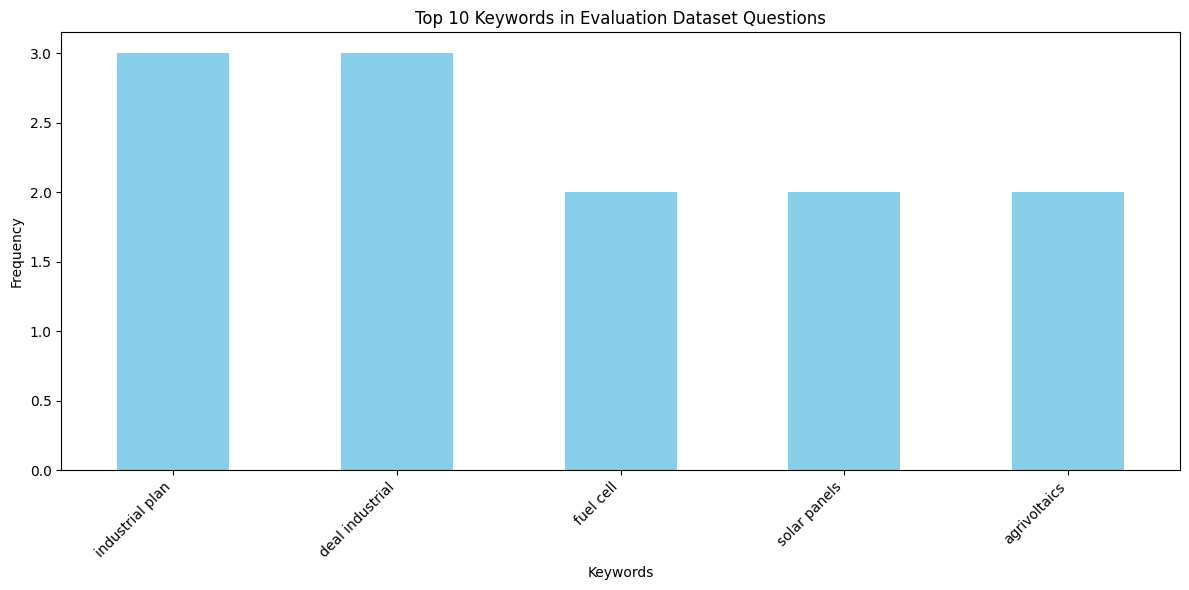

In [ ]:
# Main themes of the questions with keybert
kw_model = KeyBERT()

# Extract keywords for each question
keywords = []
for question in eval_df["question"]:
    keywords.extend(kw_model.extract_keywords(question, keyphrase_ngram_range=(1, 2), top_n=3))  # Extract top 3 keywords/phrases

# Flatten the list and count keyword frequencies
all_keywords = []
for sublist in keywords:
    for item in sublist:
        if isinstance(item, tuple) and len(item) >= 2:
            all_keywords.append(item[0])  # Append the keyword (first element)
        else:
            all_keywords.append(item)
keyword_counts = pd.Series(all_keywords).value_counts().head(5)  # Get top 5 frequent keywords

# Create a bar plot
plt.figure(figsize=(12, 6))
keyword_counts.plot(kind="bar", color="skyblue")
plt.title("Top 10 Keywords in Evaluation Dataset Questions")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


##### Subsampling

In order to avoid excessive computational cost and very long processing times for the media dataset (up to 2 hours for semantic chunking), we subsample the media dataset to 5000 articles.

In [ ]:
media_df.shape

(20108, 6)

In [ ]:
patent_df.shape

(28881, 8)

Make sure to keep the evaluation articles in the sample:

In [ ]:
eval_articles_df = media_df[media_df["url"].isin(eval_df["article_url"])]
eval_articles_df[["title", "domain", "url"]].head()

,title,domain,url
4385,Agrivoltaics Goes Nuclear On California Prairie,cleantechnica,cleantechnica.com/2022/12/18/agrivoltaics-goes-nuclear-on-california-prairie
4542,The Wait For Hydrogen Fuel Cell Electric Aircraft Just Got Shorter,cleantechnica,cleantechnica.com/2023/01/02/the-wait-for-hydrogen-fuel-cell-electric-aircraft-just-got-shorter/#zox-comments-button
4876,Leclanché’ s new disruptive battery boosts energy density,energyvoice,sgvoice.energyvoice.com/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energy-density
5015,Quality Control System for Ocean Temperature In-Situ Profiles,azocleantech,azocleantech.com/news.aspx?newsID=32873
5090,European Commission introduces Green Deal Industrial Plan – pv magazine International,pv-magazine,pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan


In [ ]:
print(eval_articles_df["url"].unique().shape)
print(eval_df["article_url"].unique().shape)

(20,)
(21,)


In [ ]:
def do_stratification(
        df: pd.DataFrame,
        column: str,
        sample_size: int,
        seed: int = 42
) -> pd.DataFrame:
    res_df = df.copy()
    indx = df.groupby(column, group_keys=False)[column].apply(lambda x: x.sample(n=int(sample_size/len(df) * len(x)), random_state=seed)).index.to_list()
    return res_df.loc[indx]

In [ ]:
sample_df = do_stratification(media_df, "domain", 5000, 69)
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df = sample_df[~sample_df["url"].isin(eval_articles_df["url"])]
sample_df = pd.concat([sample_df, eval_articles_df])
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5001 entries, 16138 to 13677
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          5001 non-null   object
 1   date           5001 non-null   object
 2   content        5001 non-null   object
 3   domain         5001 non-null   object
 4   url            5001 non-null   object
 5   clean_content  5001 non-null   object
dtypes: object(6)
memory usage: 273.5+ KB


The distribution of the articles per domain is still the same as before the sampling:

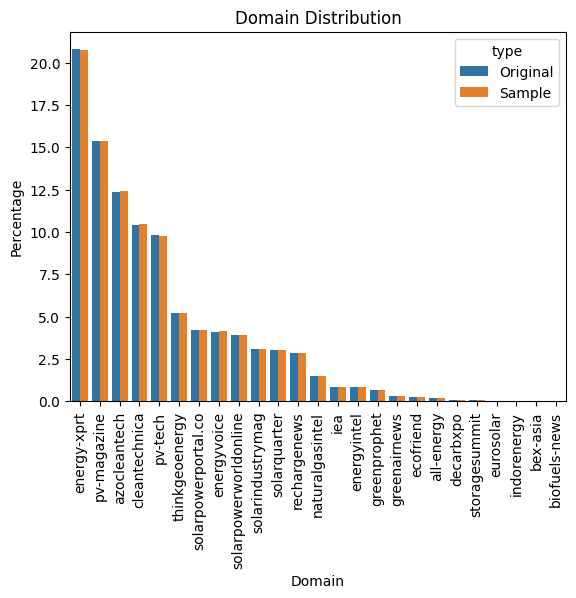

In [ ]:
original_domain_counts = media_df["domain"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df["domain"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Saving the media, patent, sample and evaluation datasets
media_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/media_df.csv', index=False)
patent_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/patent_df.csv', index=False)
eval_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/eval_df.csv', index=False)
sample_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/sample_df.csv', index=False)

## 2. Generate and Categorize Q&A Pairs

In [ ]:
## Mount the google drive and check that the datasets are there
from google.colab import drive
drive.mount('/content/drive')
!pwd
!ls '/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/'

Mounted at /content/drive
/content
chunk_keywords.json			      media_test_sentence_ORIGINAL.csv
chunks_folder				      media_train.csv
CleanTech_22-24_updated.json		      media_train_sentence.csv
cleantech_media_dataset_v3_2024-10-28.csv     media_train_sentence_ORIGINAL.csv
cleantech_rag_evaluation_data_2024-09-20.csv  media_val_sentence.csv
df_media_v2.csv				      patent_df.csv
df_patent_v2.csv			      patent_test.csv
distilbert_model			      patent_test_sentence.csv
distilbert_similarity_model.pth		      patent_test_sentence_ORIGINAL.csv
doc2vec_media_model_dm.model		      patent_train.csv
doc2vec_media_model.model		      patent_train_sentence.csv
doc2vec_patent_model_dm.model		      patent_train_sentence_ORIGINAL.csv
doc2vec_patent_model.model		      patent_val_sentence.csv
eval_df.csv				      RG65.csv
glove.6B.zip				      sample_df.csv
media_df.csv				      S_BERT.model
media_test.csv				      S_BERT_patent.model
media_test_sentence.csv			      sts-train.csv


In [ ]:
## Loading the datasets
media_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/media_df.csv')
patent_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/patent_df.csv')
eval_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/eval_df.csv')
sample_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/sample_df.csv')

In [ ]:
# If there is a GPU available:
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print ('There are %d GPU(s) available.' % torch.cuda.device_count())
    print ('We will use the GPU:', torch.cuda.get_device_name(0))
# If not:
else:
    print ('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

model_kwargs = {'device': device, "trust_remote_code": True}
model_kwargs

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


{'device': device(type='cuda'), 'trust_remote_code': True}

### 2.1. Creating the Chunks

For our RAG system we need to constitute what amounts to our own "embedding database". It will be consituted of the Q&A pairs we will be generating.

As a first step, we need to chunk the content needed for Q&A pairs accordingly. In our specific use case, we want to chunk into "paragraphs" or as close to paragraphs as possible.

Note that from this section onwards, we will be inspired by and sometimes following Prof. Dr. Daniel Perruchoud’s tutorial on RAG theory
and implementation (https://github.com/LuciferUchiha/Cleantech-RAG?tab=readme-ov-file) to put in place our RAG system.

We have several chunking strategies we could consider:

- Recursive Chunking: This strategy involves recursively splitting the article into smaller chunks based on the article structure such as paragraphs and sentences until the chunk size is less than or equal to the maximum chunk size.

This could be our best choice. But are there any newlines in the contents of patents and media datasets?

In [ ]:
media_df["clean_content"].map(lambda x: x.count("\n")).sum()

0

In [ ]:
media_df["content"].map(lambda x: x.count("\n")).sum()

0

In [ ]:
patent_df["clean_abstract"].map(lambda x: x.count("\n")).sum()

0

In [ ]:
patent_df["abstract"].map(lambda x: x.count("\n")).sum()

755

In [ ]:
patent_df.head(2)

,publication_number,country_code,title,abstract,publication_date,inventor,cpc_code,clean_abstract
0,AU-2016208290-B2,AU,Closed loop control system for heliostats,CLOSED LOOP CONTROL SYSTEM FOR HELIOSTATS \nAbstract \nDescribed herein is a control system for a solar energy collection apparatus (1). The \napparatus includes a plurality of individually angularly controllable heliostats (3) disposed \n5 adjacent to a central receiver (5). The heliostats are able to be tilted to reflect solar energy \ntowards a target region of the central receiver (5) as a beam of solid angle. The control \nsystem includes a measuring device (23) capable of being scanned across a surface of \nthe central receiver (5) including the target region. The measuring device (23) includes a \ndistribution (31) of photo sensors (33) configured to sense the presence of the beam from \n10 each heliostat. The control system further includes a controller (21) for performing a \nclosed-loop control procedure (43) to iteratively vary a pointing direction of each heliostat \nto bring the respective beam into the target region.\n2/6 \n---- --- 33 \n25 \n27 5 \n9 \n23 3 1 \n29\n35 \n7 \n15 \n19 \n13 \n21 17 \nFigure 2,2022-03-17,"BURTON, ALEXANDER","G05D3/12, F24S2050/25",closed loop control system for heliostats abstract described herein is a control system for a solar energy collection apparatus (1). the apparatus includes a plurality of individually angularly controllable heliostats (3) disposed 5 adjacent to a central receiver (5). the heliostats are able to be tilted to reflect solar energy towards a target region of the central receiver (5) as a beam of solid angle. the control system includes a measuring device (23) capable of being scanned across a surface of the central receiver (5) including the target region. the measuring device (23) includes a distribution (31) of photo sensors (33) configured to sense the presence of the beam from 10 each heliostat. the control system further includes a controller (21) for performing a closed-loop control procedure (43) to iteratively vary a pointing direction of each heliostat to bring the respective beam into the target region. 2/6 ---- --- 33 25 27 5 9 23 3 1 29 35 7 15 19 13 21 17 figure 2
1,AU-2016321918-B2,AU,Device for capturing solar energy,"The invention relates to a device for capturing solar energy, including a plurality of single-axis solar trackers (S1-S5), each one having a long structure (4) on which a plurality of photovoltaic panels (2) are fitted, and a tubular rotating shaft (1) attached to a lower side of the structure (4). A plurality of supporting feet (20) rotatably support the tubular rotating shafts (1) of the various single-axis solar trackers (S1-S5) coaxially aligned on the ground. A motor rotates the tubular rotating shafts (1) according to the relative movements of the sun. Positive and negative conductive cables (3a, 3b) which conduct electrical energy generated by the photovoltaic panels (2), connected in series, of the different single-axis solar trackers (S1-S5) are housed inside at least one of the tubular rotating shafts (1).",2022-04-07,"LÓPEZ ONA, Sergio, ROS RUÍZ, Antonio José","H02S40/34, F24S2030/11, H02S20/32, F24S30/425, Y02E10/50, Y02E10/47, F24S2030/11, F24S2030/15, F24S30/425, F24S25/12, F24S25/12, F24S2030/15, H02S40/34, Y02E10/47, H02S20/32","the invention relates to a device for capturing solar energy, including a plurality of single-axis solar trackers (s1-s5), each one having a long structure (4) on which a plurality of photovoltaic panels (2) are fitted, and a tubular rotating shaft (1) attached to a lower side of the structure (4). a plurality of supporting feet (20) rotatably support the tubular rotating shafts (1) of the various single-axis solar trackers (s1-s5) coaxially aligned on the ground. a motor rotates the tubular rotating shafts (1) according to the relative movements of the sun. positive and negative conductive cables (3a, 3b) which conduct electrical en

There are none in the media dataset, even in the uncleaned content. The patents' uncleaned abstracts appear to have newlines, but these do not denote paragraphs. Therefore, the recursive splitter focuses on sentences.

- Semantic Chunking: This strategy involves splitting the article into chunks based on semantic boundaries. This strategy finds boundaries between sentences that are semantically different and splits the article at these boundaries to create chunks. To do this we will need to use an embedding model to calculate the similarity between sentences. These embedding models will then also be used in the retrieval step to find the most relevant chunks.

#### 2.1.1. Sample Media Dataset

Here below we create the chunking function:

In [ ]:
def get_recursive_splitter(chunk_size: int, chunk_overlap: int) -> TextSplitter:
    return RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", "(?<=\. )", " ", ""],
        length_function=len,
    )

In [ ]:

embedding_models = {
    "mini": HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", model_kwargs=model_kwargs),
    "bge-m3": HuggingFaceEmbeddings(model_name="BAAI/bge-m3", model_kwargs=model_kwargs),
    "gte": HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-base-en-v1.5", model_kwargs=model_kwargs),
}


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/72.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We now apply the chunking on the media dataset:

In [ ]:
recursive_256_splitter = get_recursive_splitter(256, 64)
recursive_1024_splitter = get_recursive_splitter(1024, 128)
semantic_splitter = SemanticChunker(
    embedding_models["gte"], breakpoint_threshold_type="percentile"
)
splitters = {
    "recursive_256": recursive_256_splitter,
    "recursive_1024": recursive_1024_splitter,
    "semantic": semantic_splitter
}

In [ ]:
chunks_folder = Path('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/chunks_folder')
chunks_folder = chunks_folder / "chunks"
if not chunks_folder.exists():
    chunks_folder.mkdir()

In [ ]:
def get_or_create_chunks(df: pd.DataFrame, text_splitter: TextSplitter, splitter_name: str) -> List[Document]:
    chunks_file = chunks_folder / f"{splitter_name}_chunks.json"
    if chunks_file.exists():
        with open(chunks_file, "r") as file:
            chunks = [Document(**chunk) for chunk in json.load(file)]
        print(f"Loaded {len(chunks)} chunks from {chunks_file}")
    else:
        chunks = chunk_documents(df, text_splitter)
        with open(chunks_file, "w") as file:
            json.dump([doc.dict() for doc in chunks], file, indent=4)
        print(f"Saved {len(chunks)} chunks to {chunks_file}")
    return chunks

In [ ]:
def chunk_documents(df: pd.DataFrame, text_splitter: TextSplitter):
    chunks = []
    id = 0
    for _, row in tqdm(df.iterrows(), total=len(df)):
        article_content = row['clean_content']
        title = row['title']
        # we add the title to the content as it might be relevant to the question
        full_text = title + ": " + article_content
        char_chunks = text_splitter.split_text(full_text)
        for chunk in char_chunks:
                id += 1
                # add metadata to the chunk for potential later use
                metadata = {
                    'title': row['title'],
                    'url': row['url'],
                    'domain': row['domain'],
                    'id': id,
                }
                chunks.append(Document(
                    page_content=chunk,
                    metadata=metadata,
                ))
    # The function should return the list of chunks
    return chunks

chunks = {}
for splitter_name, splitter in splitters.items():
    chunks[splitter_name] = get_or_create_chunks(sample_df, splitter, splitter_name)

100%|██████████| 5001/5001 [00:07<00:00, 669.64it/s]


Saved 124605 chunks to /content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/chunks_folder/chunks/recursive_256_chunks.json


100%|██████████| 5001/5001 [00:06<00:00, 789.57it/s]


Saved 28277 chunks to /content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/chunks_folder/chunks/recursive_1024_chunks.json


100%|██████████| 5001/5001 [31:56<00:00,  2.61it/s]


Saved 12543 chunks to /content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/chunks_folder/chunks/semantic_chunks.json


In [ ]:
!pip install textwrap --quiet # Installing the textwrap module
import textwrap

for splitter_name, splitter_chunks in chunks.items():
    print(f"{splitter_name} chunks:")
    # Wrap the text to 150 characters per line
    wrapped_text = textwrap.fill(splitter_chunks[0].page_content, width=150)
    print(wrapped_text)
    print()

ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap
recursive_256 chunks:
Charging Ahead: The UK’ s Electric Vehicle Revolution: ["change is sweeping the highways of the united kingdom. being responsible for 88 percent of
passenger miles and 79 percent of freight traffic, england's highways are crucial. aside from that, despite

recursive_1024 chunks:
Charging Ahead: The UK’ s Electric Vehicle Revolution: ["change is sweeping the highways of the united kingdom. being responsible for 88 percent of
passenger miles and 79 percent of freight traffic, england's highways are crucial. aside from that, despite making up just 2 percent of roads,
national highways ' strategic road network ( srn) handles one-third of passenger miles and two-thirds of freight miles in england. connectivity is
crucial for investment, community empowerment, and efficient domestic and international supply chains in the srn.",

The semantic chunking appears to be the longest and to capture the most information but the 1024 characters ones seem also acceptable. We choose the 1024 chunking for our "paragraphs".

#### 2.1.2. Patent Dataset

We proceed the same way for the patents dataset. Since the patents' text is much shorter than the articles', there was no need for sampling.

In [ ]:
chunks_folder = Path('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/chunks_folder')
chunks_folder = chunks_folder / "chunks_patent"
if not chunks_folder.exists():
    chunks_folder.mkdir()

In [ ]:
patent_df.columns

Index(['publication_number', 'country_code', 'title', 'abstract',
       'publication_date', 'inventor', 'cpc_code', 'clean_abstract'],
      dtype='object')

In [ ]:
def chunk_documents(df: pd.DataFrame, text_splitter: TextSplitter):
    chunks = []
    id = 0
    for _, row in tqdm(df.iterrows(), total=len(df)):
        patent_content = row['clean_abstract']
        title = row['title']
        # we add the title to the content as it might be relevant to the question
        full_text = title + ": " + patent_content
        char_chunks = text_splitter.split_text(full_text)
        for chunk in char_chunks:
                id += 1
                # add metadata to the chunk for potential later use
                metadata = {
                    'title': row['title'],
                    'publication_date': row['publication_date'],
                    "inventor": row['inventor'],
                    "cpc_code": row['cpc_code'],
                    'id': id,
                }
                chunks.append(Document(
                    page_content=chunk,
                    metadata=metadata,
                ))
    # The function should return the list of chunks
    return chunks

chunks = {}
for splitter_name, splitter in splitters.items():
    chunks[splitter_name] = get_or_create_chunks(patent_df, splitter, splitter_name)

100%|██████████| 28881/28881 [00:14<00:00, 1989.16it/s]


Saved 189343 chunks to /content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/chunks_folder/chunks_patent/recursive_256_chunks.json


100%|██████████| 28881/28881 [00:12<00:00, 2363.85it/s]


Saved 51949 chunks to /content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/chunks_folder/chunks_patent/recursive_1024_chunks.json


100%|██████████| 28881/28881 [19:19<00:00, 24.91it/s]


Saved 38156 chunks to /content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/chunks_folder/chunks_patent/semantic_chunks.json


In [ ]:
for splitter_name, splitter_chunks in chunks.items():
    print(f"{splitter_name} chunks:")
    # Wrap the text to 150 characters per line
    wrapped_text = textwrap.fill(splitter_chunks[0].page_content, width=150)
    print(wrapped_text)
    print()

recursive_256 chunks:
Closed loop control system for heliostats: closed loop control system for heliostats abstract described herein is a control system for a solar energy
collection apparatus (1). the apparatus includes a plurality of individually angularly controllable

recursive_1024 chunks:
Closed loop control system for heliostats: closed loop control system for heliostats abstract described herein is a control system for a solar energy
collection apparatus (1). the apparatus includes a plurality of individually angularly controllable heliostats (3) disposed 5 adjacent to a central
receiver (5). the heliostats are able to be tilted to reflect solar energy towards a target region of the central receiver (5) as a beam of solid
angle. the control system includes a measuring device (23) capable of being scanned across a surface of the central receiver (5) including the target
region. the measuring device (23) includes a distribution (31) of photo sensors (33) configured to sense the p

We prefer the 1024 characters chunks since they capture the most information.

### 2.2. Relevant chunks selection

#### 2.2.1. Media Dataset

In [ ]:
kw_model = KeyBERT()
chunk_keywords = []
for chunk in chunks["recursive_1024"]:
  keywords = kw_model.extract_keywords(chunk.page_content, keyphrase_ngram_range=(1, 2), top_n=5)
  chunk_keywords.append(keywords)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
## We save the chunk_keywords in the google drive to avoid running the code again
# Define the path on your Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/Computational Language Technologies/content/'  # Adjust as needed
file_name = 'chunk_keywords_media.json'
full_path = os.path.join(drive_path, file_name)

# Save keywords to Google Drive
with open(full_path, 'w') as f:
  json.dump(chunk_keywords, f, indent=4)

In [ ]:
#To load the chunk_keywords if needed
drive_path = '/content/drive/My Drive/Colab Notebooks/Computational Language Technologies/content/'  # Adjust as needed
file_name = 'chunk_keywords_media.json'
full_path = os.path.join(drive_path, file_name)
with open(full_path, 'r') as f:
    chunk_keywords = json.load(f)

In [ ]:
# Create a list of keyword strings for each chunk
keyword_strings = [" ".join([kw[0] for kw in kws]) for kws in chunk_keywords]

# Vectorize the keywords using TF-IDF
vectorizer = TfidfVectorizer()
keyword_vectors = vectorizer.fit_transform(keyword_strings)

# Cluster the chunks using k-means
num_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(keyword_vectors)

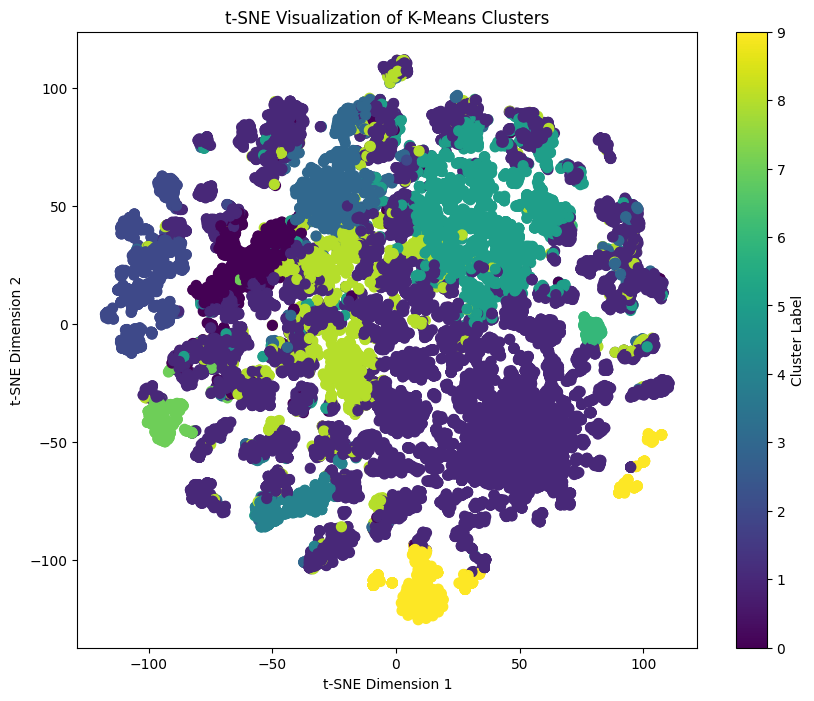

In [ ]:
# Apply Truncated SVD before t-SNE
svd = TruncatedSVD(n_components=50)  # Keep the top 50 components
svd_result = svd.fit_transform(keyword_vectors)

tsne = TSNE(n_components=2, random_state=0, init='random')  # Use 'random' initialization
tsne_embeddings = tsne.fit_transform(svd_result)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
selected_chunks = []
for cluster_id in range(num_clusters):
  cluster_chunks = [chunks["recursive_1024"][i] for i, label in enumerate(cluster_labels) if label == cluster_id]

  # Select 5 chunks from each cluster
  selected_chunks.extend(cluster_chunks[:6])

In [ ]:
# Create a list to store the data for the dataframe
data = []

# Iterate through selected chunks and extract information
for i, chunk in enumerate(selected_chunks):
  cluster_id = cluster_labels[i]
  keywords = " ".join([kw[0] for kw in chunk_keywords[i]])
  chunk_content = chunk.page_content

  # Append the data to the list
  data.append([cluster_id, keywords, chunk_content])

# Create the dataframe
selected_chunks_media_df = pd.DataFrame(data, columns=["cluster", "keywords", "chunk"])

# Display the dataframe
selected_chunks_media_df.head(2)

,cluster,keywords,chunk
0,1,england highways electric vehicles vehicles uk uk electric traffic england,"Drax Approved for New £500m Cruachan 2 Pumped Storage Hydro Project: ['we use cookies to enhance your experience. by continuing to browse this site you agree to our use of cookies. more info.', 'drax group today ( july 25) announced it has secured development consent from the scottish government for its plans to build a new pound 500m underground pumped storage hydro plant at its existing cruachan facility in argyll.', 'the announcement was made during a visit by scotland' s first minister humza yousaf to drax' s cruachan power station on the shores of loch awe.', '"" today' s announcement from drax and the scottish government is not only exciting news for cruachan power station and the wider renewable energy industry, it' s a really positive step forward for the transition to net-zero in scotland.', '"" long-duration electricity storage, such as pumped storage hydro, will be essential for ensuring energy security and keeping energy bills low for consumers as we decarbonise our energy system. and the extension"
1,4,emissions 2035 vehicles uk cars 2030 2035 uk zero emissions,"Thin-Film and Printable Battery Markets: 2010, Nanomarkets Report: ["""", 'thin-film and printable battery markets: 2010 report examines the business opportunities for thin-film and printable batteries across a broad range of applications for which they are claimed to be suited. for each of these applications, thin-film and printable battery markets: 2010 report examines the requirements for power sources and compare current and future performance of tf/printable batteries with the other power sources that may be used for each applications.', ""thin-film and printable battery markets: 2010 report also makes a critical examination of the business case `` stories '' being told by the leading manufacturers of tf/printable batteries to ascertain the degree to which they jibe with market realities. thin-film and printable battery markets: 2010 report analyzed the likely evolution of materials and battery chemistries used in the novel batteries discussed in this report which covers both the electrodes and electrolyte."


In [ ]:
len(selected_chunks)

60

In [ ]:
# Print keywords for each cluster
for cluster_id in range(num_clusters):
    # Get chunk indices for the current cluster
    chunk_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]

    # Get keywords for chunks in the current cluster
    cluster_keywords = [chunk_keywords[i] for i in chunk_indices]

    # Print cluster ID and keywords
    print(f"Cluster {cluster_id}:")

    # Flatten and print keywords
    all_keywords_in_cluster = [keyword[0] for sublist in cluster_keywords for keyword in sublist]
    print(all_keywords_in_cluster)
    print("-" * 50)

Output hidden; open in https://colab.research.google.com to view.

We have 10 clusters in total. As we can see here, the topics are rather varied which should insure that we get at least 4-5 categories of questions. We do however remove the 10th cluster, because it is mostly related to Azocleantech articles (this may be due to unwanted text which repeatedly mentions Azocleantech):

- Cluster 0: storage of energy (hydropower, electrical, batteries)
- Cluster 1: electric vehicles
- Cluster 2: geothermal energy
- Cluster 3: renewable energy
- Cluster 4: emissions
- Cluster 5: solar energy
- Cluster 6: recycling
- Cluster 7: Tesla-related articles
- Cluster 8: initiatives and conferences
- Cluster 9: Azocleantech's articles - To remove

In [ ]:
selected_chunks_media_df["cluster"].value_counts()

,count
cluster,
1,32
8,11
3,7
4,4
5,1


In [ ]:
# Removing the 10th cluster
cluster_10_indices = selected_chunks_media_df[selected_chunks_media_df['cluster'] == 9].index
selected_chunks_media_df = selected_chunks_media_df.drop(cluster_10_indices)
selected_chunks_media_df = selected_chunks_media_df.reset_index(drop=True)

In [ ]:
selected_chunks_media_df.shape

(55, 4)

In [ ]:
# Saving the dataset on the drive
selected_chunks_media_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/selected_chunks_media_df.csv', index=False)

#### 2.2.2. Patents Dataset

In [ ]:
kw_model = KeyBERT()
chunk_keywords = []
for chunk in chunks["recursive_1024"]:
  keywords = kw_model.extract_keywords(chunk.page_content, keyphrase_ngram_range=(1, 2), top_n=5)
  chunk_keywords.append(keywords)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
## We save the chunk_keywords in the google drive to avoid running the code again
# Define the path on your Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/Computational Language Technologies/content/'  # Adjust as needed
file_name = 'chunk_keywords.json'
full_path = os.path.join(drive_path, file_name)

# Save keywords to Google Drive
with open(full_path, 'w') as f:
  json.dump(chunk_keywords, f, indent=4)


In [ ]:
#To load the chunk_keywords if needed
drive_path = '/content/drive/My Drive/Colab Notebooks/Computational Language Technologies/content/'  # Adjust as needed
file_name = 'chunk_keywords.json'
full_path = os.path.join(drive_path, file_name)
with open(full_path, 'r') as f:
    chunk_keywords = json.load(f)

In [ ]:
# Create a list of keyword strings for each chunk
keyword_strings = [" ".join([kw[0] for kw in kws]) for kws in chunk_keywords]

# Vectorize the keywords using TF-IDF
vectorizer = TfidfVectorizer()
keyword_vectors = vectorizer.fit_transform(keyword_strings)

# Cluster the chunks using k-means
num_clusters = 10  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(keyword_vectors)

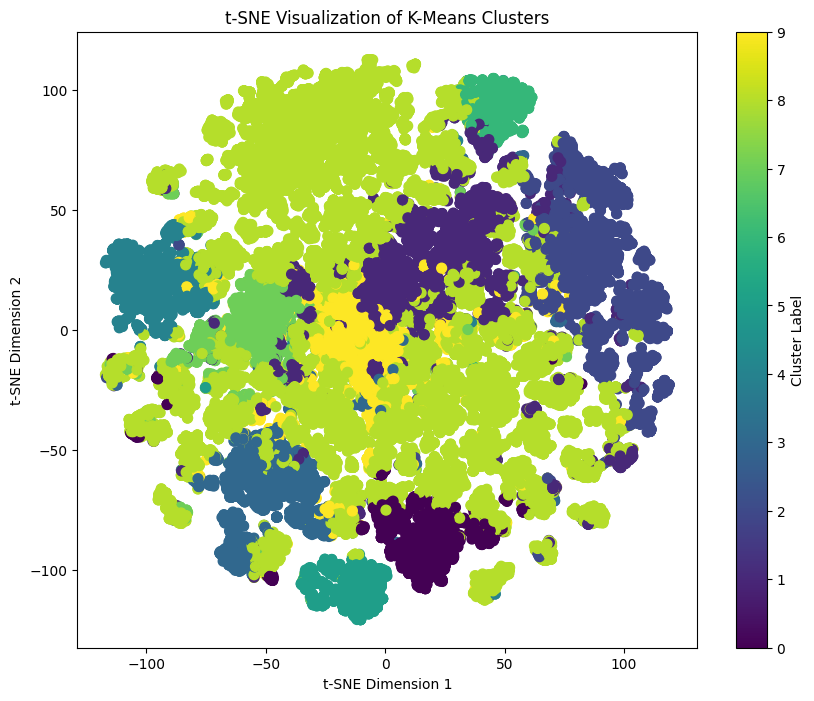

In [ ]:
# Apply Truncated SVD before t-SNE
svd = TruncatedSVD(n_components=50)  # Keep the top 50 components
svd_result = svd.fit_transform(keyword_vectors)

tsne = TSNE(n_components=2, random_state=0, init='random')  # Use 'random' initialization
tsne_embeddings = tsne.fit_transform(svd_result)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
selected_chunks = []
for cluster_id in range(num_clusters):
  cluster_chunks = [chunks["recursive_1024"][i] for i, label in enumerate(cluster_labels) if label == cluster_id]

  # Select 5 chunks from each cluster
  selected_chunks.extend(cluster_chunks[:5])

In [ ]:
# Create a list to store the data for the dataframe
data = []

# Iterate through selected chunks and extract information
for i, chunk in enumerate(selected_chunks):
  cluster_id = cluster_labels[i]
  keywords = " ".join([kw[0] for kw in chunk_keywords[i]])
  chunk_content = chunk.page_content

  # Append the data to the list
  data.append([cluster_id, keywords, chunk_content])

# Create the dataframe
selected_chunks_patent_df = pd.DataFrame(data, columns=["cluster", "keywords", "chunk"])

# Display the dataframe
selected_chunks_patent_df.head(2)

,cluster,keywords,chunk
0,8,control solar controllable heliostats control heliostats heliostat control receiver heliostats,"Systems and methods for hydro-based electric power generation: a hydrodynamic power generation assembly (10) and method of use therefor for generating electrical power from the combination of kinetic energy, hydrostatic energy, and turbulent energy of water. the power generation assembly (10) comprises a water accelerator assembly (40a, 40b) comprising a support structure (15) which is at least partially buoyant and a baffle panel member (or an array of baffle panel members) having an opening, inter-panel spacing, or flow passageway around the baffle panel(s). a hydropower converter (55) is supported from, by, or on the support structure (15) and is operatively coupled to a generator. the hydropower converter (55) is positioned behind baffle assembly (40a, 40b). water flowing through or around the baffle assembly has an increased velocity relative the ambient current and therefore is capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of"
1,8,respective beam beam target beam heliostat heliostat bring,capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of hydropower converters suitable for use with the invention are turbines and water wheels.


In [ ]:
len(selected_chunks)

50

In [ ]:
# Saving the dataset on the drive
selected_chunks_patent_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/selected_chunks_patent_df.csv', index=False)

In [ ]:
# Print keywords for each cluster
for cluster_id in range(num_clusters):
    # Get chunk indices for the current cluster
    chunk_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]

    # Get keywords for chunks in the current cluster
    cluster_keywords = [chunk_keywords[i] for i in chunk_indices]

    # Print cluster ID and keywords
    print(f"Cluster {cluster_id}:")

    # Flatten and print keywords
    all_keywords_in_cluster = [keyword[0] for sublist in cluster_keywords for keyword in sublist]
    print(all_keywords_in_cluster)
    print("-" * 50)

Output hidden; open in https://colab.research.google.com to view.

We have 10 clusters in total. As we can see here, the topics are rather varied which should insure that we get at least 4-5 categories of questions:

- Cluster 0: hydropower
- Cluster 1: solar panels
- Cluster 2: photothermal energy
- Cluster 3: wind power and air purification
- Cluster 4: hydrogen storage
- Cluster 5: geothermal power
- Cluster 6: light generation
- Cluster 7: temperature profile
- Cluster 8: heliostats
- Cluster 9: subsea energy storagy

The selection is a more restricted:

In [ ]:
selected_chunks_patent_df["cluster"].value_counts()

,count
cluster,
8,23
1,14
2,4
9,4
3,2
0,2
7,1


### 2.2. Generate the Q&A Pairs

We now generate Q&A pairs for the media and patent dataset separately before putting them together.

#### 2.2.1. Media Dataset

In [ ]:
# Read dataset
selected_chunks_media_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/selected_chunks_media_df.csv')

In [ ]:
selected_chunks_media_df.head()

,cluster,keywords,chunk
0,1,england highways electric vehicles vehicles uk uk electric traffic england,"Drax Approved for New £500m Cruachan 2 Pumped Storage Hydro Project: ['we use cookies to enhance your experience. by continuing to browse this site you agree to our use of cookies. more info.', 'drax group today ( july 25) announced it has secured development consent from the scottish government for its plans to build a new pound 500m underground pumped storage hydro plant at its existing cruachan facility in argyll.', 'the announcement was made during a visit by scotland' s first minister humza yousaf to drax' s cruachan power station on the shores of loch awe.', '"" today' s announcement from drax and the scottish government is not only exciting news for cruachan power station and the wider renewable energy industry, it' s a really positive step forward for the transition to net-zero in scotland.', '"" long-duration electricity storage, such as pumped storage hydro, will be essential for ensuring energy security and keeping energy bills low for consumers as we decarbonise our energy system. and the extension"
1,4,emissions 2035 vehicles uk cars 2030 2035 uk zero emissions,"Thin-Film and Printable Battery Markets: 2010, Nanomarkets Report: ["""", 'thin-film and printable battery markets: 2010 report examines the business opportunities for thin-film and printable batteries across a broad range of applications for which they are claimed to be suited. for each of these applications, thin-film and printable battery markets: 2010 report examines the requirements for power sources and compare current and future performance of tf/printable batteries with the other power sources that may be used for each applications.', ""thin-film and printable battery markets: 2010 report also makes a critical examination of the business case `` stories '' being told by the leading manufacturers of tf/printable batteries to ascertain the degree to which they jibe with market realities. thin-film and printable battery markets: 2010 report analyzed the likely evolution of materials and battery chemistries used in the novel batteries discussed in this report which covers both the electrodes and electrolyte."
2,1,electric vehicles cars dcarbonise zero emissions dcarbonise scotland electric vehicle,"and battery chemistries used in the novel batteries discussed in this report which covers both the electrodes and electrolyte. thin-film and printable battery markets: 2010 report also reviews the progress being made with manufacturing processes."", ""thin-film and printable battery markets: 2010 report brings together nanomarkets ' deep experience in the thin-film, organic and printable electronics sector with its analysis of the latest developments in the battery field including new products, technology breakthroughs, new licensing, financial and marketing arrangements and recent m & a activity. and while the main objective of thin-film and printable battery markets: 2010 report is to focus on the evolving opportunities in tf/printable batteries, thin-film and printable battery markets: 2010 report will also seek to explain where there have been apparent failures and analyze why these have occurred."", 'the sensi+(tm) is a laser-based analyzer used for monitoring natural gas quality.', 'the cypher es afm from"
3,1,street charging chargepoints england electric vehicles electric vehicle charging rates,"to achieve net zero.', 'ongoing efforts to reduce greenhouse gas emissions have spurred investment in green energy, with an average of dollar 600 billion per year spent on strategies to achieve a post-carbon economy.', 'between 2017 and 2018, the electric vehicle market saw a 65 percent growth, with electric vehicles being produced by multiple manufacturers.', 'surging demand for these ultra-low-emission vehicles is expected to grow, with 23 million electric passenger vehicles predicted to be produced by 2030.', 'rechargeable lithium-ion batteries are at the

In [ ]:
selected_chunks_media_df["chunk"].dtype

dtype('O')

In [ ]:
selected_chunks_media_df["chunk"].astype('string')
selected_chunks_media_df['chunk'] = selected_chunks_media_df['chunk'].apply(lambda x: ''.join(x))
selected_chunks_media_df['title'] = selected_chunks_media_df['chunk'].apply(lambda x: x.split(': [')[0] if ': [' in x else x)
selected_chunks_media_df['chunk'] = selected_chunks_media_df['chunk'].apply(lambda x: x.split(': [')[1] if ': [' in x else x)
selected_chunks_media_df.head(2)

,cluster,keywords,chunk,title
0,1,england highways electric vehicles vehicles uk uk electric traffic england,"'we use cookies to enhance your experience. by continuing to browse this site you agree to our use of cookies. more info.', 'drax group today ( july 25) announced it has secured development consent from the scottish government for its plans to build a new pound 500m underground pumped storage hydro plant at its existing cruachan facility in argyll.', 'the announcement was made during a visit by scotland' s first minister humza yousaf to drax' s cruachan power station on the shores of loch awe.', '"" today' s announcement from drax and the scottish government is not only exciting news for cruachan power station and the wider renewable energy industry, it' s a really positive step forward for the transition to net-zero in scotland.', '"" long-duration electricity storage, such as pumped storage hydro, will be essential for ensuring energy security and keeping energy bills low for consumers as we decarbonise our energy system. and the extension",Drax Approved for New £500m Cruachan 2 Pumped Storage Hydro Project
1,4,emissions 2035 vehicles uk cars 2030 2035 uk zero emissions,""""", 'thin-film and printable battery markets: 2010 report examines the business opportunities for thin-film and printable batteries across a broad range of applications for which they are claimed to be suited. for each of these applications, thin-film and printable battery markets: 2010 report examines the requirements for power sources and compare current and future performance of tf/printable batteries with the other power sources that may be used for each applications.', ""thin-film and printable battery markets: 2010 report also makes a critical examination of the business case `` stories '' being told by the leading manufacturers of tf/printable batteries to ascertain the degree to which they jibe with market realities. thin-film and printable battery markets: 2010 report analyzed the likely evolution of materials and battery chemistries used in the novel batteries discussed in this report which covers both the electrodes and electrolyte.","Thin-Film and Printable Battery Markets: 2010, Nanomarkets Report"


Here we try out the LLM to see what kind of Q&A pairs we get. We notice that there should be clear instructions as to the structure of the output. Some constraints also had to be put in place since the LLM would sometimes take the text about website cookies or subscription and create Q&A pairs out of it.

We refer to Dr. Lipenkova's chapter on RAG revision for prompt engineering and refinement (p.16 and p.19).

In [ ]:
# Loading environment variables from .env file
load_dotenv()

# Accessing the API key
api_key = os.getenv("OPENAI_API_KEY")

# Initializing the language model
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Prompt, instruction and context
prompt = ChatPromptTemplate.from_template (
    "As a cleantech data scientist, analyze the following text and generate two insightful questions with answers: {text}"
    "output the questions and answers as follows : Question 1: \n Answer 1: \n Question 2: \n Answer 2: \n"
    "Focus on identifying trends, gaps, and noteworthy findings in clean technology within this text."
    "Observe the following constraints: \n-Use only information from the provided sources \n-Do not create questions about website cookies or subscription services"
)
chain = prompt | llm | StrOutputParser()
chain.invoke({"text": "'drax group today ( july 25) announced it has secured development consent from the scottish government for its plans to build a new pound 500m underground pumped storage hydro plant at its existing cruachan facility in argyll.', 'the announcement was made during a visit by scotland' s first minister humza yousaf to drax' s cruachan power station on the shores of loch awe. today' s announcement from drax and the scottish government is not only exciting news for cruachan power station and the wider renewable energy industry, it' s a really positive step forward for the transition to net-zero in scotland. long-duration electricity storage, such as pumped storage hydro, will be essential for ensuring energy security and keeping energy bills low for consumers as we decarbonise our energy system. and the extension"})

"Question 1: What is the significance of the new underground pumped storage hydro plant at Drax's existing Cruachan facility for the transition to net-zero in Scotland?\n\nAnswer 1: The new underground pumped storage hydro plant is a positive step forward for the transition to net-zero in Scotland as it will provide essential long-duration electricity storage, ensuring energy security and keeping energy bills low for consumers as the energy system is decarbonized.\n\nQuestion 2: How does the development consent secured from the Scottish government for the new pound 500m underground pumped storage hydro plant at Drax's Cruachan facility contribute to the wider renewable energy industry in Scotland?\n\nAnswer 2: The development consent secured for the new underground pumped storage hydro plant at Drax's Cruachan facility is exciting news for the wider renewable energy industry in Scotland, as it signifies progress towards achieving net-zero emissions and highlights the importance of long

In [ ]:
# Create an empty list to store Q&A pairs
qa_pairs = []

# Iterate through chunks and generate Q&A pairs
for index, row in selected_chunks_media_df.iterrows():
    chunk_text = row['chunk']

    # Run the chain with the chunk text as input
    response = chain.invoke(chunk_text)

    # Parsing
    question_answer_blocks = response.split("Question ")
    # removing empty parts
    question_answer_blocks = [i for i in question_answer_blocks if i]

    for question_answer_block in question_answer_blocks:
          try:
            # Removing the question/answer number
            question, answer = question_answer_block[2:].split("Answer ", 1) # Split by "Answer "
            # appending to our list
            qa_pairs.append({
                'chunk_index': index,
                "cluster": row["cluster"],
                'chunk_title': row['title'],
                'chunk_text': chunk_text,
                'chunk_keywords': row['keywords'],
                'question': question.strip(),
                'answer': answer.strip()
            })
          except ValueError:
            print(f"Skipping chunk {index} due to unexpected response format.")

# Create a DataFrame from the collected Q&A pairs
qa_df = pd.DataFrame(qa_pairs)

In [ ]:
# Remove "1:" and "2:" from answers
qa_df["answer"] = qa_df["answer"].str.replace(r"^[1-2]:", "", regex=True)

Manually reviewing the generated questions and answers, we can see that they are relevant to the extracts and also to the overall topic of clean technology. The two questions per text appear to be equally insightful and also diverse despite the texts being short. There are no questions referencing the websites' cookies or subscription services.

In [ ]:
qa_df[60:80]

,chunk_index,cluster,chunk_title,chunk_text,chunk_keywords,question,answer
60,30,1,Renewables Project Delivers Green Energy for the Green Screen,"'we use cookies to enhance your experience. by continuing to browse this site you agree to our use of cookies. more info.', 'sse energy solutions has completed the installation of a 3 megawatt solar panel system on the rooftops of sky studios elstree which will supply at least 40 percent of the site' s annual energy consumption over the year, with early data suggesting it is likely to be even more.', 'image credit: sse energy solutions/shutterstock.com', 'the state-of-the-art film and tv studio complex now features 7,400 solar panels, reducing carbon emissions by 487 tons, the equivalent of 22,371 trees being planted annually and enough to power over 200 homes.', 'sse has been sky' s energy partner for over a decade, providing in excess of 100 gigawatth of renewable energy each year across a variety of the media company' s sites.', ""sky studios elstree, which aims to be the world's most sustainable film and tv studio, is the latest significant",iot things iot occupancy iot iot devices iot mark,What percentage of Sky Studios Elstree's annual energy consumption is supplied by the 3 megawatt solar panel system installed by SSE Energy Solutions?,"The solar panel system installed by SSE Energy Solutions is expected to supply at least 40 percent of Sky Studios Elstree's annual energy consumption, with early data suggesting it may be even more."
61,30,1,Renewables Project Delivers Green Energy for the Green Screen,"'we use cookies to enhance your experience. by continuing to browse this site you agree to our use of cookies. more info.', 'sse energy solutions has completed the installation of a 3 megawatt solar panel system on the rooftops of sky studios elstree which will supply at least 40 percent of the site' s annual energy consumption over the year, with early data suggesting it is likely to be even more.', 'image credit: sse energy solutions/shutterstock.com', 'the state-of-the-art film and tv studio complex now features 7,400 solar panels, reducing carbon emissions by 487 tons, the equivalent of 22,371 trees being planted annually and enough to power over 200 homes.', 'sse has been sky' s energy partner for over a decade, providing in excess of 100 gigawatth of renewable energy each year across a variety of the media company' s sites.', ""sky studios elstree, which aims to be the world's most sustainable film and tv studio, is the latest significant",iot things iot occupancy iot iot devices iot mark,"How many solar panels were installed by SSE Energy Solutions at Sky Studios Elstree, and what is the impact on carbon emissions and energy production?","SSE Energy Solutions installed 7,400 solar panels at Sky Studios Elstree, reducing carbon emissions by 487 tons annually, equivalent to planting 22,371 trees, and providing enough energy to power over 200 homes."
62,31,8,Harnessing Solar Energy: New Method Improves Readings of Double-Sided Panels,""""", 'a leading laboratory in photonics and renewable energy at the university of ottawa has developed a new method for measuring the solar energy produced by bifacial solar panels, the double-sided solar technology which is expected to meet increased global energy demands moving forward.\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b', '\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200b\u200bpublished in the journal joule, this study from the sunlab team in the faculties of engineering and science proposes a characterization method that will improve the measurement of bifacial panels indoors by considering external effects of ground cover such as snow, grass and soil. this will provide a way to consistently test bifacial solar panel performance indoors that accurately represents how the panels will perform outdoors.', 'with bifacial photovoltaics expected to provide",energy harv

In [ ]:
qa_df.shape

(110, 7)

In [ ]:
# Saving the dataset on the drive
qa_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/qa_media.csv', index=False)

In [ ]:
qa_df["cluster"].value_counts()

,count
cluster,
1,64
8,22
3,14
4,8
5,2


We use the previously constituted clusters to narrow down our examination of themes, sub-themes and types of questions:

- Cluster 1: the main theme is electric vehicles. Types of questions we find in this category are: developments in car battery technology by various companies. Investment into electric vehicle charging also seems to be very prevalent. Some more remote topics concern energy storage and wind farms. There are also some topics on "green concrete" or how to make buildings' construction more sustainable. There are also some solar and recycling topics.

- Cluster 3: the main theme is renewable energy. One prevalent theme is renewable energy storage. There are also some recycling themes

- Cluster 4: the main theme is emissions. thin-film and printable batteries are a recurrent theme as well as recycling.

- Cluster 5:The questions concern the All-Energy event

- Cluster 8: the main theme is initiatives and conferences. Some relevant topics include geothermal heat pumps.

Note that not all clusters were sampled, which explains why there are some which do not appear in the dataframe.

On the basis of the above, we can cluster the questions on the basis of the following prevalent categories:

- EV batteries
- Recycling (which is recurrent across several clusters)
- Energy storage
- Wind energy
- Solar Energy
- Construction
- Geothermal heat pumps

In [ ]:
qa_df[qa_df["cluster"] == 1][:50]

,chunk_index,cluster,chunk_title,chunk_text,chunk_keywords,question,answer
0,0,1,Drax Approved for New £500m Cruachan 2 Pumped Storage Hydro Project,"'we use cookies to enhance your experience. by continuing to browse this site you agree to our use of cookies. more info.', 'drax group today ( july 25) announced it has secured development consent from the scottish government for its plans to build a new pound 500m underground pumped storage hydro plant at its existing cruachan facility in argyll.', 'the announcement was made during a visit by scotland' s first minister humza yousaf to drax' s cruachan power station on the shores of loch awe.', '"" today' s announcement from drax and the scottish government is not only exciting news for cruachan power station and the wider renewable energy industry, it' s a really positive step forward for the transition to net-zero in scotland.', '"" long-duration electricity storage, such as pumped storage hydro, will be essential for ensuring energy security and keeping energy bills low for consumers as we decarbonise our energy system. and the extension",england highways electric vehicles vehicles uk uk electric traffic england,What is the significance of the development consent secured by Drax Group from the Scottish government for its new underground pumped storage hydro plant at the Cruachan facility?,The development consent secured by Drax Group for the new underground pumped storage hydro plant at the Cruachan facility is significant as it represents a major step towards the transition to net-zero in Scotland and the wider renewable energy industry.
1,0,1,Drax Approved for New £500m Cruachan 2 Pumped Storage Hydro Project,"'we use cookies to enhance your experience. by continuing to browse this site you agree to our use of cookies. more info.', 'drax group today ( july 25) announced it has secured development consent from the scottish government for its plans to build a new pound 500m underground pumped storage hydro plant at its existing cruachan facility in argyll.', 'the announcement was made during a visit by scotland' s first minister humza yousaf to drax' s cruachan power station on the shores of loch awe.', '"" today' s announcement from drax and the scottish government is not only exciting news for cruachan power station and the wider renewable energy industry, it' s a really positive step forward for the transition to net-zero in scotland.', '"" long-duration electricity storage, such as pumped storage hydro, will be essential for ensuring energy security and keeping energy bills low for consumers as we decarbonise our energy system. and the extension",england highways electric vehicles vehicles uk uk electric traffic england,"Why is long-duration electricity storage, such as pumped storage hydro, considered essential for ensuring energy security and keeping energy bills low for consumers during the decarbonization of the energy system?","Long-duration electricity storage, like pumped storage hydro, is crucial for maintaining energy security and affordable energy prices for consumers as the energy system undergoes decarbonization. This type of storage helps balance the intermittency of renewable energy sources and ensures a reliable energy supply."
4,2,1,"and battery chemistries used in the novel batteries discussed in this report which covers both the electrodes and electrolyte. thin-film and printable battery markets: 2010 report also reviews the progress being made with manufacturing processes."", ""thin-film and printable battery markets: 2010 report brings together nanomarkets ' deep experience in the thin-film, organic and printable electronics sector with its analysis of the latest developments in the battery field including new products, technology breakthroughs, new licensing, financial and marketing arrangements and recent m & a activity. and while the main objective of thin-film and printable battery markets: 2010 report is to focus on the evolving opportunities in t

In [ ]:
qa_df[qa_df["cluster"] == 3].head(5)

,chunk_index,cluster,chunk_title,chunk_text,chunk_keywords,question,answer
22,11,3,"finance and funding, cyber security community and local energy and much more. dcarbonise sessions were aimed at decarbonisation of the built environment, heat, transport, cities/places, industry and of the supply chain.', 'the 2024 all-energy and dcarbonise ( 15-16 may 2024) conference programme will feature three areas - the conference in the theatres/ conference rooms at sec glasgow; our vibrant show floor theatres on the exhibition show floor; and academic poster presentations in the research hub.', 'once again there will be no call for speakers for the main all-energy/dcarbonise 2024 main conference. this approach in 2023 ensured we worked to specific aims on each and every session resulting in increased relevance, topicality, and attendance. autumn 2023 will be spent soaking up thoughts from stakeholders at every level. let us know of topics you believe it vital to address. we have no ready-written tablet of stone but are here to listen, learn and act. see what we covered in 2023 here. what should be","finance and funding, cyber security community and local energy and much more. dcarbonise sessions were aimed at decarbonisation of the built environment, heat, transport, cities/places, industry and of the supply chain.', 'the 2024 all-energy and dcarbonise ( 15-16 may 2024) conference programme will feature three areas - the conference in the theatres/ conference rooms at sec glasgow; our vibrant show floor theatres on the exhibition show floor; and academic poster presentations in the research hub.', 'once again there will be no call for speakers for the main all-energy/dcarbonise 2024 main conference. this approach in 2023 ensured we worked to specific aims on each and every session resulting in increased relevance, topicality, and attendance. autumn 2023 will be spent soaking up thoughts from stakeholders at every level. let us know of topics you believe it vital to address. we have no ready-written tablet of stone but are here to listen, learn and act. see what we covered in 2023 here. what should be",wind ambitions infrastructure conference headline sponsor renewable energy renewable,"What specific areas within the built environment, heat, transport, cities/places, industry, and the supply chain were targeted for decarbonization during the dcarbonise sessions?","The dcarbonise sessions were aimed at decarbonisation of the built environment, heat, transport, cities/places, industry, and of the supply chain."
23,11,3,"finance and funding, cyber security community and local energy and much more. dcarbonise sessions were aimed at decarbonisation of the built environment, heat, transport, cities/places, industry and of the supply chain.', 'the 2024 all-energy and dcarbonise ( 15-16 may 2024) conference programme will feature three areas - the conference in the theatres/ conference rooms at sec glasgow; our vibrant show floor theatres on the exhibition show floor; and academic poster presentations in the research hub.', 'once again there will be no call for speakers for the main all-energy/dcarbonise 2024 main conference. this approach in 2023 ensured we worked to specific aims on each and every session resulting in increased relevance, topicality, and attendance. autumn 2023 will be spent soaking up thoughts from stakeholders at every level. let us know of topics you believe it vital to address. we have no ready-written tablet of stone but are here to listen, learn and act. see what we covered in 2023 here. what should be","finance and funding, cyber security community and local energy and much more. dcarbonise sessions were aimed at decarbonisation of the built environment, heat, transport, cities/places, industry and of the supply chain.', 'the 2024 all-energy and dcarbonise ( 15-16 may 2024) conference programme will feature three areas - the conference in the theatres/ conference rooms at sec glasgow; our vibrant show floor theatres on 

In [ ]:
qa_df[qa_df["cluster"] == 4]

,chunk_index,cluster,chunk_title,chunk_text,chunk_keywords,question,answer
2,1,4,"Thin-Film and Printable Battery Markets: 2010, Nanomarkets Report",""""", 'thin-film and printable battery markets: 2010 report examines the business opportunities for thin-film and printable batteries across a broad range of applications for which they are claimed to be suited. for each of these applications, thin-film and printable battery markets: 2010 report examines the requirements for power sources and compare current and future performance of tf/printable batteries with the other power sources that may be used for each applications.', ""thin-film and printable battery markets: 2010 report also makes a critical examination of the business case `` stories '' being told by the leading manufacturers of tf/printable batteries to ascertain the degree to which they jibe with market realities. thin-film and printable battery markets: 2010 report analyzed the likely evolution of materials and battery chemistries used in the novel batteries discussed in this report which covers both the electrodes and electrolyte.",emissions 2035 vehicles uk cars 2030 2035 uk zero emissions,"What specific applications are thin-film and printable batteries claimed to be suited for, and how do their current and future performance compare to other power sources for these applications?","Thin-film and printable batteries are claimed to be suited for a broad range of applications, and the 2010 report examines their requirements for power sources and compares their performance with other power sources for each application."
3,1,4,"Thin-Film and Printable Battery Markets: 2010, Nanomarkets Report",""""", 'thin-film and printable battery markets: 2010 report examines the business opportunities for thin-film and printable batteries across a broad range of applications for which they are claimed to be suited. for each of these applications, thin-film and printable battery markets: 2010 report examines the requirements for power sources and compare current and future performance of tf/printable batteries with the other power sources that may be used for each applications.', ""thin-film and printable battery markets: 2010 report also makes a critical examination of the business case `` stories '' being told by the leading manufacturers of tf/printable batteries to ascertain the degree to which they jibe with market realities. thin-film and printable battery markets: 2010 report analyzed the likely evolution of materials and battery chemistries used in the novel batteries discussed in this report which covers both the electrodes and electrolyte.",emissions 2035 vehicles uk cars 2030 2035 uk zero emissions,"How does the 2010 report analyze the business case stories presented by leading manufacturers of thin-film and printable batteries, and what is the assessment of the degree to which these stories align with market realities?",The 2010 report makes a critical examination of the business case stories being told by the leading manufacturers of thin-film and printable batteries to determine how well they align with market realities.
58,29,4,"carbon black, a well-known conductor, into a concrete mixture with water. once the ingredients were combined, they then let the mix cure. the introduction of water then encouraged the natural formation of a porous rhizomatic network throughout the structure as it reacted with the cement. the carbon black then moved into these spaces to create wire-like structures as the cement set.', 'this revolutionary achievement bears the promise of redefining energy storage paradigms, opening pathways to sustainable and efficient power solutions.', ""mit's supercapacitor, made from carbon-black concrete, boasts remarkable energy storage capacity and impressive high-discharge rate capabilities, all while demonstrating self-similarity. this remarkable material ushers in a realm of possibilities, ranging from roadways primed for electric vehicle charging to 

In [ ]:
qa_df[qa_df["cluster"] == 5]

,chunk_index,cluster,chunk_title,chunk_text,chunk_keywords,question,answer
92,46,5,"in clean tech: how are we shaping the future?' which demonstrates their ( and our) wide range of interests - all. of course, with line-ups of luminaries. ""', 'turning his attention to the exhibition, jonathan heastie explained: "" our exhibitor list already resembles a ' who' s who', and a-z of organisations from throughout the sectors we serve including abb, centrica energy, clarke energy, ecotricity, edf energy, enercon, ge renewable energy, invest northern ireland, muirhall energy, natural power, parat halvorsen, ripple energy, siemens energy/siemens gamesa, smartestenergy, statkraft uk, sse, xodus, zx lidars. recent additions include business france, czech trade and the hy5 -the green hydrogen initiative of northern germany who join individual exhibitors from denmark, france, germany, ireland, italy, the netherlands and norway, as well as throughout the uk.', 'full information for potential exhibitors is at www.all-energy.co.uk/24 all-energy takes pride in being the uk' s largest low carbon energy and","in clean tech: how are we shaping the future?' which demonstrates their ( and our) wide range of interests - all. of course, with line-ups of luminaries. ""', 'turning his attention to the exhibition, jonathan heastie explained: "" our exhibitor list already resembles a ' who' s who', and a-z of organisations from throughout the sectors we serve including abb, centrica energy, clarke energy, ecotricity, edf energy, enercon, ge renewable energy, invest northern ireland, muirhall energy, natural power, parat halvorsen, ripple energy, siemens energy/siemens gamesa, smartestenergy, statkraft uk, sse, xodus, zx lidars. recent additions include business france, czech trade and the hy5 -the green hydrogen initiative of northern germany who join individual exhibitors from denmark, france, germany, ireland, italy, the netherlands and norway, as well as throughout the uk.', 'full information for potential exhibitors is at www.all-energy.co.uk/24 all-energy takes pride in being the uk' s largest low carbon energy and",sustainable film solar panels megawatt solar renewable energy renewables project,Which countries are represented by individual exhibitors at the All-Energy event?,"The individual exhibitors at the All-Energy event come from Denmark, France, Germany, Ireland, Italy, the Netherlands, Norway, and throughout the UK."
93,46,5,"in clean tech: how are we shaping the future?' which demonstrates their ( and our) wide range of interests - all. of course, with line-ups of luminaries. ""', 'turning his attention to the exhibition, jonathan heastie explained: "" our exhibitor list already resembles a ' who' s who', and a-z of organisations from throughout the sectors we serve including abb, centrica energy, clarke energy, ecotricity, edf energy, enercon, ge renewable energy, invest northern ireland, muirhall energy, natural power, parat halvorsen, ripple energy, siemens energy/siemens gamesa, smartestenergy, statkraft uk, sse, xodus, zx lidars. recent additions include business france, czech trade and the hy5 -the green hydrogen initiative of northern germany who join individual exhibitors from denmark, france, germany, ireland, italy, the netherlands and norway, as well as throughout the uk.', 'full information for potential exhibitors is at www.all-energy.co.uk/24 all-energy takes pride in being the uk' s largest low carbon energy and","in clean tech: how are we shaping the future?' which demonstrates their ( and our) wide range of interests - all. of course, with line-ups of luminaries. ""', 'turning his attention to the exhibition, jonathan heastie explained: "" our exhibitor list already resembles a ' who' s who', and a-z of organisations from throughout the sectors we serve including abb, centrica energy, clarke energy, ecotricity, edf energy, enercon, ge renewable energy, invest northern ireland, muirhall energy, natural power, parat halvorsen

In [ ]:
qa_df[qa_df["cluster"] == 8]

,chunk_index,cluster,chunk_title,chunk_text,chunk_keywords,question,answer
12,6,8,Charging Ahead: The UK’ s Electric Vehicle Revolution,"""change is sweeping the highways of the united kingdom. being responsible for 88 percent of passenger miles and 79 percent of freight traffic, england's highways are crucial. aside from that, despite making up just 2 percent of roads, national highways ' strategic road network ( srn) handles one-third of passenger miles and two-thirds of freight miles in england. connectivity is crucial for investment, community empowerment, and efficient domestic and international supply chains in the srn."", ""as they glide past their diesel and gasoline-powered competitors, sleek electric cars ( evs) are bringing with them the promise of a more environmentally friendly future. an important strategic change driving the uk's ambitious decarbonisation targets is the recent uptick in the popularity of electric vehicles."", 'in an effort to speed up the transition to electric vehicles, the uk government has enacted a number of regulations. according to a may 2019 report by",energy conference programme renewables energy community dcarbonise conference renewable energy,"What percentage of passenger miles does the national highways' strategic road network (SRN) handle in England, despite making up just 2 percent of roads?",The SRN handles one-third of passenger miles in England.
13,6,8,Charging Ahead: The UK’ s Electric Vehicle Revolution,"""change is sweeping the highways of the united kingdom. being responsible for 88 percent of passenger miles and 79 percent of freight traffic, england's highways are crucial. aside from that, despite making up just 2 percent of roads, national highways ' strategic road network ( srn) handles one-third of passenger miles and two-thirds of freight miles in england. connectivity is crucial for investment, community empowerment, and efficient domestic and international supply chains in the srn."", ""as they glide past their diesel and gasoline-powered competitors, sleek electric cars ( evs) are bringing with them the promise of a more environmentally friendly future. an important strategic change driving the uk's ambitious decarbonisation targets is the recent uptick in the popularity of electric vehicles."", 'in an effort to speed up the transition to electric vehicles, the uk government has enacted a number of regulations. according to a may 2019 report by",energy conference programme renewables energy community dcarbonise conference renewable energy,How are electric vehicles (EVs) contributing to the UK's ambitious decarbonisation targets?,The recent uptick in the popularity of EVs is an important strategic change driving the UK's decarbonisation targets.
24,12,8,"Geothermal Heat Pump Consortium: Quotes, Address, Contact","'we use cookies to enhance your experience. by continuing to browse this site you agree to our use of cookies. more info.', 'for more than a decade, the geothermal heat pump consortium has been working to increase the awareness and use of geoexchange technology throughout the united states and the world.', ""we believe that environmental stewardship and the responsible use of energy resources are crucial to the nation's economy and our quality of life. toward that end, increasing the use of geoexchange technology will not only dramatically reduce our national energy consumption and greenhouse gas emissions, but also will also slash its users ' energy costs, and our nation's dependence on fossil fuels."", 'as a cooperative venture, the consortium counts among its partners electric utilities, equipment manufacturers, architects, designers, engineers, contractors, builders, drillers, energy service companies, and other private sector companies that",energy uk hydrogen initiative energy siemens ge renewable energy invest,What key benefits does the geothermal heat pump consortium believe increasing the use of geoexchange technology will bring to the nation's econo

#### 2.2.2. Patent Dataset

In [ ]:
# Read dataset
selected_chunks_patent_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/selected_chunks_patent_df.csv')

In [ ]:
selected_chunks_patent_df.head(5)

,cluster,keywords,chunk
0,8,control solar controllable heliostats control heliostats heliostat control receiver heliostats,"Systems and methods for hydro-based electric power generation: a hydrodynamic power generation assembly (10) and method of use therefor for generating electrical power from the combination of kinetic energy, hydrostatic energy, and turbulent energy of water. the power generation assembly (10) comprises a water accelerator assembly (40a, 40b) comprising a support structure (15) which is at least partially buoyant and a baffle panel member (or an array of baffle panel members) having an opening, inter-panel spacing, or flow passageway around the baffle panel(s). a hydropower converter (55) is supported from, by, or on the support structure (15) and is operatively coupled to a generator. the hydropower converter (55) is positioned behind baffle assembly (40a, 40b). water flowing through or around the baffle assembly has an increased velocity relative the ambient current and therefore is capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of"
1,8,respective beam beam target beam heliostat heliostat bring,capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of hydropower converters suitable for use with the invention are turbines and water wheels.
2,1,capturing solar solar trackers solar energy photovoltaic panels photovoltaic,Hydropower system for generating and storing energy: disclosed is a pumped hydro energy storage system for generating and storing energy and method of operating a wastewater facility in conjunction with the 5 pumped hydro energy storage system. the pumped hydro energy storage system comprises at least one upper water reservoir and a lower water reservoir and a penstock that interconnects the reservoirs. at least part of the lower reservoir may be a tunnel to accommodate wastewater and/or stor megawattater flow. the pumped hydro energy storage system also comprises at least one hydropower system for 10 generating electricity by causing water to flow from the upper reservoir through one or more turbines into the lower water reservoir and a provides a pumping function for storing energy by pumping water up from the lower water reservoir. 17946136_1 (0d co0 i-- co a&#39; izv-
3,1,solar panel panel solar shade solar window shade bracket solar,"Prefabricated, modular hydropower foundation system for soil conditions: a foundation system for modular hydropower systems and methods for constructing same. the foundation system is compatible with soils, particularly soils that are relatively loose or compressible, and thereby advantageous for the widespread implementation of low head modular hydropower systems. the foundation system includes pipe piles; sheet piles configured to be arranged transverse to the pipe piles; pile caps configured to be seated on top of the plurality of pipe piles; and a beam base slab configured to be securely positioned on top of the pile caps. a kit for the foundation system is also disclosed."
4,8,energy forecasts forecasts electric meteorological forecasts forecasts coefficient utility forecasted,"Operation method of hydropower station open-close type combined technical water supply system: the invention discloses an operation method of a hydropower station open-closed combined technical water supply system, and belongs to the field of hydropower station technical water supply systems. the invention comprises an open type water supply device, a closed type water supply device, a first operating valve group and a second operating valve group; one end of the open water supply device is connected with a water source, one path of the other end of the open water supply device is sequentially connected with the first operation valve group, the cooling object, the second operation valve group and the tail water of the hydropower sta

In [ ]:
selected_chunks_patent_df["chunk"].dtype

dtype('O')

In [ ]:
selected_chunks_patent_df["chunk"].astype('string')

Once again we try out the LLM to see what kind of Q&A pairs we get. We notice that there should be clear instructions as to the structure of the output. Not as many constraints needed to be used. We tried to specify the origin of the text (abstracts of patents) because we thought processing would be better, but instead the LLM kept referring to the text as a patent abstract and it did not improve the Q&A pairs.  

In [ ]:
# Loading environment variables from .env file
load_dotenv()

# Accessing the API key
api_key = os.getenv("OPENAI_API_KEY")

# Initializing the language model
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Prompt, instruction and context
prompt = ChatPromptTemplate.from_template (
    "As a cleantech data scientist, analyze the following text and generate two insightful questions with answers: {text}"
    "output the questions and answers as follows : Question 1: \n Answer 1: \n Question 2: \n Answer 2: \n"
    "Focus on identifying trends, gaps, and noteworthy findings in clean technology within this text."
    "Observe the following constraints: \n-Use only information from the provided sources"
)
chain = prompt | llm | StrOutputParser()
chain.invoke({"text": "Hydropower system for generating and storing energy: disclosed is a pumped hydro energy storage system for generating and storing energy and method of operating a wastewater facility in conjunction with the 5 pumped hydro energy storage system. the pumped hydro energy storage system comprises at least one upper water reservoir and a lower water reservoir and a penstock that interconnects the reservoirs. at least part of the lower reservoir may be a tunnel to accommodate wastewater and/or stor megawattater flow. the pumped hydro energy storage system also comprises at least one hydropower system for 10 generating electricity by causing water to flow from the upper reservoir through one or more turbines into the lower water reservoir and a provides a pumping function for storing energy by pumping water up from the lower water reservoir. 17946136_1 (0d co0 i-- co a&#39; izv-"})

'Question 1: What are the key components of the pumped hydro energy storage system described in the text?\n\nAnswer 1: The pumped hydro energy storage system consists of at least one upper water reservoir, a lower water reservoir, a penstock connecting the reservoirs, a hydropower system for generating electricity, and a pumping function for storing energy.\n\nQuestion 2: How does the pumped hydro energy storage system integrate with a wastewater facility according to the text?\n\nAnswer 2: The lower reservoir of the pumped hydro energy storage system may include a tunnel to accommodate wastewater and/or store water flow, allowing for the operation of a wastewater facility in conjunction with the energy generation and storage system.'

In [ ]:
# Create an empty list to store Q&A pairs
qa_pairs = []

# Iterate through chunks and generate Q&A pairs
for index, row in selected_chunks_patent_df.iterrows():
    chunk_text = row['chunk']

    # Run the chain with the chunk text as input
    response = chain.invoke(chunk_text)

    # Parsing
    question_answer_blocks = response.split("Question ")
    # removing empty parts
    question_answer_blocks = [i for i in question_answer_blocks if i]

    for question_answer_block in question_answer_blocks:
          try:
            # Removing the question/answer number
            question, answer = question_answer_block[2:].split("Answer ", 1) # Split by "Answer "
            # appending to our list
            qa_pairs.append({
                'chunk_index': index,
                "cluster": row["cluster"],
                'chunk_text': chunk_text,
                'chunk_keywords': row['keywords'],
                'question': question.strip(),
                'answer': answer.strip()
            })
          except ValueError:
            print(f"Skipping chunk {index} due to unexpected response format.")

# Create a DataFrame from the collected Q&A pairs
qa_patent_df = pd.DataFrame(qa_pairs)

In [ ]:
qa_patent_df.head(20)

,chunk_index,cluster,chunk_text,chunk_keywords,question,answer
0,0,8,"Systems and methods for hydro-based electric power generation: a hydrodynamic power generation assembly (10) and method of use therefor for generating electrical power from the combination of kinetic energy, hydrostatic energy, and turbulent energy of water. the power generation assembly (10) comprises a water accelerator assembly (40a, 40b) comprising a support structure (15) which is at least partially buoyant and a baffle panel member (or an array of baffle panel members) having an opening, inter-panel spacing, or flow passageway around the baffle panel(s). a hydropower converter (55) is supported from, by, or on the support structure (15) and is operatively coupled to a generator. the hydropower converter (55) is positioned behind baffle assembly (40a, 40b). water flowing through or around the baffle assembly has an increased velocity relative the ambient current and therefore is capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of",control solar controllable heliostats control heliostats heliostat control receiver heliostats,What types of energy sources are utilized in the hydrodynamic power generation assembly for generating electrical power?,"1: The hydrodynamic power generation assembly utilizes kinetic energy, hydrostatic energy, and turbulent energy of water to generate electrical power."
1,0,8,"Systems and methods for hydro-based electric power generation: a hydrodynamic power generation assembly (10) and method of use therefor for generating electrical power from the combination of kinetic energy, hydrostatic energy, and turbulent energy of water. the power generation assembly (10) comprises a water accelerator assembly (40a, 40b) comprising a support structure (15) which is at least partially buoyant and a baffle panel member (or an array of baffle panel members) having an opening, inter-panel spacing, or flow passageway around the baffle panel(s). a hydropower converter (55) is supported from, by, or on the support structure (15) and is operatively coupled to a generator. the hydropower converter (55) is positioned behind baffle assembly (40a, 40b). water flowing through or around the baffle assembly has an increased velocity relative the ambient current and therefore is capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of",control solar controllable heliostats control heliostats heliostat control receiver heliostats,How does the design of the water accelerator assembly with a baffle panel member contribute to increasing the velocity of water flow and power generation?,"2: The baffle panel member in the water accelerator assembly creates an opening, inter-panel spacing, or flow passageway around the baffle panel(s), which accelerates the water flow, resulting in increased velocity relative to the ambient current and higher power generation capability."
2,1,8,capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of hydropower converters suitable for use with the invention are turbines and water wheels.,respective beam beam target beam heliostat heliostat bring,What are the specific types of hydropower converters mentioned as suitable for use with the invention?,1: The specific types of hydropower converters mentioned as suitable for use with the invention are turbines and water wheels.
3,1,8,capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of hydropower converters suitable for use with the invention are turbines and water wheels.,respective beam beam target beam heliostat heliostat bring,How does the invention aim to increase power generation relative to the ambient water?,2: The invention aims to increase power generation relative to the ambient water b

In [ ]:
qa_patent_df.shape

(100, 6)

In [ ]:
qa_patent_df["cluster"].value_counts()

,count
cluster,
8,46
1,28
2,8
9,8
3,4
0,4
7,2


In [ ]:
# Remove "1:" and "2:" from answers
qa_patent_df["answer"] = qa_patent_df["answer"].str.replace(r"^[1-2]:", "", regex=True)

In [ ]:
# Saving the dataset on the drive
qa_patent_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/qa_patent.csv', index=False)

We use the previously constituted clusters to narrow down our examination of themes, sub-themes and types of questions:
- Cluster 0: the main theme is hydropower, but here we find questions about solar receivers.
- Cluster 1: the main theme is solar panels. Sub-themes include: photovoltaic-solar thermal systems and wind turbines.
- Cluster 2: the main theme is photothermal energy and this is indeed the case across the cluster.
- Cluster 3: the main theme is wind power and air purification but the questions reflect moreso the themes of geothermal wells
- Cluster 7: the main theme is temperature profile but solar energy is mentioned in the questions.
- Cluster 8: the main theme is heliostats but we find questions about subsea energy storage installations and hybrid power generation systems
- Cluster 9: the main theme is subsea energy storage but we find questions about solar energy for air purification

Note that not all clusters were sampled, which explains why there are some which do not appear in the dataframe.

On the basis of the above, we can cluster the questions on the basis of the following prevalent categories:

- Solar Energy
- Wind energy
- Geothermal energy
- Subsea energy storage



In [ ]:
qa_patent_df[qa_patent_df["cluster"] == 0]

,chunk_index,cluster,chunk_text,chunk_keywords,question,answer
70,35,0,"calculating and/or supplying respectively the maximum temperature, temperature profile and/or absorbed power profile in each heat exchanger tube (6) and theoretical mechanical strains assigned to each heat exchanger tube (6) as a function of the temperature provided by the imaging devices (7, 7a, 7b, etc.), in order to control if the operating point of an area located on the solar receiver (3) is within an operating envelope (16) in the 2d-space theoretical strain/t",generator hydropower hydropower converter panel hydropower hydropower hydrodynamic power,"How can the data scientist ensure that the operating point of the area located on the solar receiver is within the operating envelope by calculating the maximum temperature, temperature profile, and absorbed power profile in each heat exchanger tube as a function of the temperature provided by the imaging devices?","The data scientist can achieve this by utilizing the data from the imaging devices (7, 7a, 7b, etc.) to calculate the maximum temperature, temperature profile, absorbed power profile in each heat exchanger tube, and theoretical mechanical strains assigned to each tube. By analyzing these data points, the data scientist can determine if the operating point falls within the operating envelope in the 2d-space theoretical strain/output."
71,35,0,"calculating and/or supplying respectively the maximum temperature, temperature profile and/or absorbed power profile in each heat exchanger tube (6) and theoretical mechanical strains assigned to each heat exchanger tube (6) as a function of the temperature provided by the imaging devices (7, 7a, 7b, etc.), in order to control if the operating point of an area located on the solar receiver (3) is within an operating envelope (16) in the 2d-space theoretical strain/t",generator hydropower hydropower converter panel hydropower hydropower hydrodynamic power,How can the data scientist optimize the performance of the solar receiver by leveraging the temperature data provided by the imaging devices and adjusting the mechanical strains assigned to each heat exchanger tube?,"The data scientist can optimize the performance of the solar receiver by using the temperature data from the imaging devices to fine-tune the mechanical strains assigned to each heat exchanger tube. By adjusting these strains based on the temperature profile, the data scientist can ensure that the operating point remains within the desired operating envelope, maximizing the efficiency of the solar receiver."
72,36,0,"A regenerative heating device: the present invention relates to a regenerative heating device comprises a heater having a heating element configured with a power source and placed within an enclosure to convert electrical energy into heat energy; a solar air heater equipped with a solar absorbing plate for heating absorbing section through the heating element where heat transfer takes place between air and absorber plate via solar energy received by the absorber plate; a blower positioned at one side of the heating element, wherein upon activation the blower unit discharges air that passes from the heating element resulting in increasing the temperature of the air instantaneously; and a packed bed reservoir filled with heat absorbing material, wherein the hot air passing through the heating elements strikes the surface of the heat absorbing material resulting in trapping of heat from the air into the material and passing remaining air in the atmosphere. 100 heater 102 solarair heater1 absorbing plate106",hydropower converters types hydropower hydropower water power turbines water,How does the regenerative heating device utilize solar energy to heat the air passing through it?,"The regenerative heating device uses a solar air heater equipped with a solar absorbing plate to heat the absorbing section through the heating element, allowing for heat transfer between air and absorber p

In [ ]:
qa_patent_df[qa_patent_df["cluster"] == 1]

,chunk_index,cluster,chunk_text,chunk_keywords,question,answer
4,2,1,Hydropower system for generating and storing energy: disclosed is a pumped hydro energy storage system for generating and storing energy and method of operating a wastewater facility in conjunction with the 5 pumped hydro energy storage system. the pumped hydro energy storage system comprises at least one upper water reservoir and a lower water reservoir and a penstock that interconnects the reservoirs. at least part of the lower reservoir may be a tunnel to accommodate wastewater and/or stor megawattater flow. the pumped hydro energy storage system also comprises at least one hydropower system for 10 generating electricity by causing water to flow from the upper reservoir through one or more turbines into the lower water reservoir and a provides a pumping function for storing energy by pumping water up from the lower water reservoir. 17946136_1 (0d co0 i-- co a&#39; izv-,capturing solar solar trackers solar energy photovoltaic panels photovoltaic,How does the pumped hydro energy storage system in this text incorporate a wastewater facility into its operation?,"The pumped hydro energy storage system includes a tunnel in the lower reservoir to accommodate wastewater and/or store water flow, allowing for the operation of a wastewater facility in conjunction with the system."
5,2,1,Hydropower system for generating and storing energy: disclosed is a pumped hydro energy storage system for generating and storing energy and method of operating a wastewater facility in conjunction with the 5 pumped hydro energy storage system. the pumped hydro energy storage system comprises at least one upper water reservoir and a lower water reservoir and a penstock that interconnects the reservoirs. at least part of the lower reservoir may be a tunnel to accommodate wastewater and/or stor megawattater flow. the pumped hydro energy storage system also comprises at least one hydropower system for 10 generating electricity by causing water to flow from the upper reservoir through one or more turbines into the lower water reservoir and a provides a pumping function for storing energy by pumping water up from the lower water reservoir. 17946136_1 (0d co0 i-- co a&#39; izv-,capturing solar solar trackers solar energy photovoltaic panels photovoltaic,What is the dual functionality of the hydropower system within the pumped hydro energy storage system?,"The hydropower system is responsible for generating electricity by flowing water from the upper reservoir through turbines into the lower reservoir, as well as providing a pumping function for storing energy by pumping water up from the lower water reservoir."
6,3,1,"Prefabricated, modular hydropower foundation system for soil conditions: a foundation system for modular hydropower systems and methods for constructing same. the foundation system is compatible with soils, particularly soils that are relatively loose or compressible, and thereby advantageous for the widespread implementation of low head modular hydropower systems. the foundation system includes pipe piles; sheet piles configured to be arranged transverse to the pipe piles; pile caps configured to be seated on top of the plurality of pipe piles; and a beam base slab configured to be securely positioned on top of the pile caps. a kit for the foundation system is also disclosed.",solar panel panel solar shade solar window shade bracket solar,"How does the use of pipe piles, sheet piles, pile caps, and a beam base slab in the foundation system make it compatible with loose or compressible soils for modular hydropower systems?","By utilizing pipe piles for stability, sheet piles for transverse support, pile caps for distributing load, and a beam base slab for secure positioning, the foundation system is able to accommodate loose or compressible soils, making it advantageous for low head modular hydropower systems."
7,3,1,"Prefabricated, modular hydropower foundation system for soi

In [ ]:
qa_patent_df[qa_patent_df["cluster"] == 2]

,chunk_index,cluster,chunk_text,chunk_keywords,question,answer
18,9,2,"Solar tracking arrangement for controlling parabolic trough solar collectors, and a thermal solar energy system: the solar tracking arrangement (300) enables a plurality of parallel arranged ptcs (302) to be directed towards the travelling sun. the solar tracking arrangement comprises a drive means (308), a transmission means (306), and a plurality of conversion means (304). the transmission means are connected with the drive means and to each of the plurality of conversion means. the transmission means is configured to convey an operating movement caused by the drive means to the plurality of conversion means, and each of the conversion means is configured to convert the conveyed operating movement into a pivoting movement of a respective one of the plurality of ptcs about a focus line, such that each of the pivoting movements directs the respective ptc towards the travelling sun. one or more of the conversion means are adjustably connected with the transmission means in a direction along the transmission",concentrating photovoltaic photovoltaic photothermal solar photovoltaic solar thermal photovoltaic solar,What role does the solar tracking arrangement play in optimizing the efficiency of the thermal solar energy system?,The solar tracking arrangement allows a plurality of parallel arranged parabolic trough solar collectors to be directed towards the traveling sun by converting operating movement into pivoting movements to ensure maximum sunlight exposure.
19,9,2,"Solar tracking arrangement for controlling parabolic trough solar collectors, and a thermal solar energy system: the solar tracking arrangement (300) enables a plurality of parallel arranged ptcs (302) to be directed towards the travelling sun. the solar tracking arrangement comprises a drive means (308), a transmission means (306), and a plurality of conversion means (304). the transmission means are connected with the drive means and to each of the plurality of conversion means. the transmission means is configured to convey an operating movement caused by the drive means to the plurality of conversion means, and each of the conversion means is configured to convert the conveyed operating movement into a pivoting movement of a respective one of the plurality of ptcs about a focus line, such that each of the pivoting movements directs the respective ptc towards the travelling sun. one or more of the conversion means are adjustably connected with the transmission means in a direction along the transmission",concentrating photovoltaic photovoltaic photothermal solar photovoltaic solar thermal photovoltaic solar,How does the adjustability of one or more conversion means along the transmission output impact the overall performance of the solar tracking arrangement?,"The adjustability of conversion means along the transmission output allows for fine-tuning of the pivoting movements of the parabolic trough solar collectors, ensuring precise alignment with the traveling sun for optimal energy capture."
36,18,2,"Wind turbine and method: a wind turbine (1), comprising a generator (17) for converting wind energy into electrical energy, a hydrogen production system (10) for producing hydrogen by means of the electrical energy, a first auxiliary group (25) of electrical consumers (22 – 24), a second auxiliary group (30) of electrical consumers (27 – 29), and an auxiliary power network (21) for powering the first auxiliary group (25) and the second auxiliary group (30), wherein only the first auxiliary group (25) can be electrically disconnected from the auxiliary power network (21) by means of one or a plurality of switch disconnectors (26) to reduce the energy consumption of the auxiliary power network (21). due to the one or the plurality of switch disconnectors (26), it is possible to disconnect the first auxiliary group (25) from power. this helps to save energy in the case that the first auxiliary gr

In [ ]:
qa_patent_df[qa_patent_df["cluster"] == 3]

,chunk_index,cluster,chunk_text,chunk_keywords,question,answer
56,28,3,"Flow control in geothermal wells: a system for regulating fluid flow in a geothermal energy production system includes a flow control device disposed in an injector well and/or a producer well, which are disposed in a subterranean region. the injector well includes an outflow port configured to inject a fluid into the region, the producer well includes an inflow port configured to receive the fluid from the region, and the outflow port and the inflow port are in fluid communication via one or more passages in the subterranean region between the injector well and the producer well. the device is configured to restrict a flow of a fluid into the producer well based on a temperature and/or a flow rate of the fluid in the flow control device. the temperature and/or the flow rate selected to maintain a temperature of the fluid entering the producer well within a selected range.",air purification wind power generator generate power purifying air,How does the flow control device regulate fluid flow in geothermal wells based on temperature and flow rate?,"The flow control device restricts the flow of fluid into the producer well by adjusting based on the temperature and flow rate of the fluid in the device, in order to maintain a desired temperature range for the fluid entering the producer well."
57,28,3,"Flow control in geothermal wells: a system for regulating fluid flow in a geothermal energy production system includes a flow control device disposed in an injector well and/or a producer well, which are disposed in a subterranean region. the injector well includes an outflow port configured to inject a fluid into the region, the producer well includes an inflow port configured to receive the fluid from the region, and the outflow port and the inflow port are in fluid communication via one or more passages in the subterranean region between the injector well and the producer well. the device is configured to restrict a flow of a fluid into the producer well based on a temperature and/or a flow rate of the fluid in the flow control device. the temperature and/or the flow rate selected to maintain a temperature of the fluid entering the producer well within a selected range.",air purification wind power generator generate power purifying air,What is the significance of having an outflow port in the injector well and an inflow port in the producer well in a geothermal energy production system?,"The outflow port in the injector well allows for the injection of fluid into the subterranean region, while the inflow port in the producer well receives the fluid, enabling fluid communication between the two wells. This setup is crucial for efficient geothermal energy production by regulating the flow of fluid between the wells."
58,29,3,"Flow control in geothermal wells: a system for regulating fluid flow in a geothermal energy production system includes a flow control device disposed in an injector well and/or a producer well, which are disposed in a subterranean region. the injector well includes an outflow port configured to inject a fluid into the region, the producer well includes an inflow port configured to receive the fluid from the region, and the outflow port and the inflow port are in fluid communication via one or more passages in the subterranean region between the injector well and the producer well. the device is configured to restrict a flow of a fluid into the producer well based on a temperature and/or a flow rate of the fluid in the flow control device. the temperature and/or the flow rate selected to maintain a temperature of the fluid entering the producer well within a selected range.",wind turbine engineering wind turbine invention wind energy axis wind,How does the flow control device in geothermal wells regulate fluid flow based on temperature and flow rate?,\nThe flow control device in geothermal wells restricts the flow of fluid into the produce

In [ ]:
qa_patent_df[qa_patent_df["cluster"] == 7]

,chunk_index,cluster,chunk_text,chunk_keywords,question,answer
22,11,7,"Method for configuring a multilayer spectral-separation filter for photovoltaic and thermal uses, and filter and generation plant associated with said method: the invention relates to a method for configuring a selective multilayer filter (1) for spectral separation of solar radiation, which filter is suitable to be disposed on photovoltaic panels for use in energy generation plants, the multilayer filter (1) comprising a plurality of layers (2) of different refractive indices and thicknesses, the method being characterised in that it comprises carrying out a series of steps to configure said multilayer filter (1) such that photovoltaic and thermal efficiency is maximised. the invention also relates to a multilayer filter (1) configured using said method. the invention further relates to a plant for generating energy by harnessing solar energy, which comprises the use of at least one multilayer filter (1) configured using said method.",temperature profile profile heat heat exchanger solar receiver function temperature,How does the method for configuring a multilayer spectral-separation filter maximize both photovoltaic and thermal efficiency?,"The method for configuring the multilayer filter involves a series of steps that ensure the filter is optimized to enhance both photovoltaic and thermal efficiency, allowing for maximum energy generation."
23,11,7,"Method for configuring a multilayer spectral-separation filter for photovoltaic and thermal uses, and filter and generation plant associated with said method: the invention relates to a method for configuring a selective multilayer filter (1) for spectral separation of solar radiation, which filter is suitable to be disposed on photovoltaic panels for use in energy generation plants, the multilayer filter (1) comprising a plurality of layers (2) of different refractive indices and thicknesses, the method being characterised in that it comprises carrying out a series of steps to configure said multilayer filter (1) such that photovoltaic and thermal efficiency is maximised. the invention also relates to a multilayer filter (1) configured using said method. the invention further relates to a plant for generating energy by harnessing solar energy, which comprises the use of at least one multilayer filter (1) configured using said method.",temperature profile profile heat heat exchanger solar receiver function temperature,What is the significance of using multilayer filters in energy generation plants that harness solar energy?,"By using multilayer filters, energy generation plants can effectively separate solar radiation spectrums, increasing the efficiency of photovoltaic panels and enhancing overall energy generation capabilities."


In [ ]:
qa_patent_df[qa_patent_df["cluster"] == 8]

,chunk_index,cluster,chunk_text,chunk_keywords,question,answer
0,0,8,"Systems and methods for hydro-based electric power generation: a hydrodynamic power generation assembly (10) and method of use therefor for generating electrical power from the combination of kinetic energy, hydrostatic energy, and turbulent energy of water. the power generation assembly (10) comprises a water accelerator assembly (40a, 40b) comprising a support structure (15) which is at least partially buoyant and a baffle panel member (or an array of baffle panel members) having an opening, inter-panel spacing, or flow passageway around the baffle panel(s). a hydropower converter (55) is supported from, by, or on the support structure (15) and is operatively coupled to a generator. the hydropower converter (55) is positioned behind baffle assembly (40a, 40b). water flowing through or around the baffle assembly has an increased velocity relative the ambient current and therefore is capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of",control solar controllable heliostats control heliostats heliostat control receiver heliostats,What types of energy sources are utilized in the hydrodynamic power generation assembly for generating electrical power?,"The hydrodynamic power generation assembly utilizes kinetic energy, hydrostatic energy, and turbulent energy of water to generate electrical power."
1,0,8,"Systems and methods for hydro-based electric power generation: a hydrodynamic power generation assembly (10) and method of use therefor for generating electrical power from the combination of kinetic energy, hydrostatic energy, and turbulent energy of water. the power generation assembly (10) comprises a water accelerator assembly (40a, 40b) comprising a support structure (15) which is at least partially buoyant and a baffle panel member (or an array of baffle panel members) having an opening, inter-panel spacing, or flow passageway around the baffle panel(s). a hydropower converter (55) is supported from, by, or on the support structure (15) and is operatively coupled to a generator. the hydropower converter (55) is positioned behind baffle assembly (40a, 40b). water flowing through or around the baffle assembly has an increased velocity relative the ambient current and therefore is capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of",control solar controllable heliostats control heliostats heliostat control receiver heliostats,How does the design of the water accelerator assembly with a baffle panel member contribute to increasing the velocity of water flow and power generation?,"The baffle panel member in the water accelerator assembly creates an opening, inter-panel spacing, or flow passageway around the baffle panel(s), which accelerates the water flow, resulting in increased velocity relative to the ambient current and higher power generation capability."
2,1,8,capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of hydropower converters suitable for use with the invention are turbines and water wheels.,respective beam beam target beam heliostat heliostat bring,What are the specific types of hydropower converters mentioned as suitable for use with the invention?,The specific types of hydropower converters mentioned as suitable for use with the invention are turbines and water wheels.
3,1,8,capable of generating more power relative to the ambient water where power generation assembly is deployed. particular types of hydropower converters suitable for use with the invention are turbines and water wheels.,respective beam beam target beam heliostat heliostat bring,How does the invention aim to increase power generation relative to the ambient water?,The invention aims to increase power generation relative to the ambient water by being capa

In [ ]:
qa_patent_df[qa_patent_df["cluster"] == 9]

,chunk_index,cluster,chunk_text,chunk_keywords,question,answer
24,12,9,"Photovoltaic power generation inverter system: a photovoltaic power generation system, which may increase the voltage of an inverter system and reduce the current of the photovoltaic power generation system under equal power conversion conditions so as to save energy and reduce costs of the photovoltaic system. the system comprises: a photovoltaic array (101), a dc conversion unit (102), a bus unit (103) and an inverter unit (104). the photovoltaic array consists of one or more photovoltaic arrays (101), and the photovoltaic arrays (101) are used for converting solar energy into electrical energy, or in other words, generating dc power and outputting a dc voltage. the bus unit (103) is used for storing the dc power outputted by the dc conversion unit (102) or directly storing the dc power outputted by the photovoltaic arrays (101) so as to increase the bus voltage of the first bus unit (103). under equal power conversion conditions, increasing the input voltage of the inverter unit (104) may effectively",subsea energy storage subsea energy storage pumped storage subsea,How does increasing the input voltage of the inverter unit (104) in a photovoltaic power generation system help in effectively reducing costs and saving energy?,"Increasing the input voltage of the inverter unit (104) allows for a reduction in current, which can help in saving energy and reducing costs of the photovoltaic system under equal power conversion conditions."
25,12,9,"Photovoltaic power generation inverter system: a photovoltaic power generation system, which may increase the voltage of an inverter system and reduce the current of the photovoltaic power generation system under equal power conversion conditions so as to save energy and reduce costs of the photovoltaic system. the system comprises: a photovoltaic array (101), a dc conversion unit (102), a bus unit (103) and an inverter unit (104). the photovoltaic array consists of one or more photovoltaic arrays (101), and the photovoltaic arrays (101) are used for converting solar energy into electrical energy, or in other words, generating dc power and outputting a dc voltage. the bus unit (103) is used for storing the dc power outputted by the dc conversion unit (102) or directly storing the dc power outputted by the photovoltaic arrays (101) so as to increase the bus voltage of the first bus unit (103). under equal power conversion conditions, increasing the input voltage of the inverter unit (104) may effectively",subsea energy storage subsea energy storage pumped storage subsea,How does the bus unit (103) play a role in storing and increasing the bus voltage of a photovoltaic power generation system?,"The bus unit (103) is used for storing the DC power outputted by the DC conversion unit (102) or directly storing the DC power outputted by the photovoltaic arrays (101) to increase the bus voltage, which can contribute to more efficient power generation and distribution within the system."
54,27,9,"energy exchange station through the geothermal water extraction pipeline, and heat energy is extracted and then conveyed to the ground for utilization. after being extracted, the geothermal water is reinjected to the geothermal reservoir through the tail water reinjection pipeline so as to control the stability of a rock stratum and realize sustainable exploitation of geothermal energy. meanwhile, coal mining can be carried out at the next working face at the same time, and cooperative exploitation of coal and geothermal energy is achieved. the exploitation method of the present disclosure has the advantages that the resource utilization rate is high, the geothermal energy exploitation utilization cost is low, and harm of the water-conducting fractured zone of the fault is turned into benefit.",air purification energy storage solar air air storage compressed air,What are the advantages of the exploitation method described in the text

#### 2.2.3. Puting Media and Patent Q&A pairs into one dataframe

We remove the "chunk_index", "title" and "cluster" columns and concatenate both datasets that we created:

In [ ]:
#Load the datsets
qa_media_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/qa_media.csv')
qa_patent_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/qa_patent.csv')

In [ ]:
qa_media_df.columns

Index(['chunk_index', 'cluster', 'chunk_title', 'chunk_text', 'chunk_keywords',
       'question', 'answer'],
      dtype='object')

In [ ]:
qa_patent_df.columns

Index(['chunk_index', 'cluster', 'chunk_text', 'chunk_keywords', 'question',
       'answer'],
      dtype='object')

In [ ]:
#drop columns
qa_media_df = qa_media_df.drop(['chunk_index', 'chunk_title', 'cluster'], axis=1)
qa_patent_df = qa_patent_df.drop(['chunk_index', 'cluster'], axis=1)

In [ ]:
# concatenate qa_media_df and qa_patent_df:
qa_df = pd.concat([qa_media_df, qa_patent_df], ignore_index=True)

In [ ]:
qa_df.columns

Index(['chunk_text', 'chunk_keywords', 'question', 'answer'], dtype='object')

In [ ]:
qa_df.shape

(210, 4)

In [ ]:
# Saving the dataset on the drive
qa_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/qa_df.csv', index=False)

#### 2.2.4. Categorize the Q&A pairs

To recapitulate, we found the following outstanding categories in the datasets:

Media Dataset:
- EV batteries
- Recycling (which is recurrent across several clusters)
- Energy storage
- Wind energy
- Solar Energy
- Construction
- Geothermal heat pumps

Patent Dataset:
- Solar Energy
- Wind energy
- Geothermal energy
- Subsea energy storage


Overall, we therefore choose the following categories for both datasets to form one single Q&A dataset:

- EV batteries
- Solar Energy
- Hydropower
- Wind Energy
- Geothermal Energy
- Energy storage
- Recycling
- Construction

We categorize the Q&A pairs :

In [ ]:
#Load the datsets
qa_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/qa_df.csv')

In [ ]:
categories = {
    "Solar Energy": ["solar", "photovoltaic", "pv", "panel", "solar farm", "sunlight", "heliostat", "photoelectric"],
    "Wind Energy": ["wind", "turbine", "offshore wind", "wind farm", "renewable", "wind power", "lamp", "grid"],
    "Geothermal Energy": ["geothermal", "heat pump", "ground source", "renewable heating", "geothermal power"],
    "Energy storage": ["storage", "battery", "pumped hydro", "thermal storage", "grid-scale", "energy storage system"],
    "Recycling": ["recycle", "recycling", "circular economy", "waste", "reuse", "repurpose", "waste management"],
    "Construction": ["building", "construction", "infrastructure", "material", "design", "architecture"],
    "Electric Vehicles and EV Batteries": ["ev battery", "electric vehicle battery","electric vehicle", "lithium-ion battery",
                     "batteries","electric passenger vehicles",
                     "battery electric vehicle", "bev battery", "highways", "chargers"],
    "Hydropower": ["hydropower", "hydroelectric", "hydro", "dam", "reservoir", "water power"]
}

categories = {
    "Solar Energy": ["solar", "photovoltaic", "pv", "panel", "solar farm", "sunlight", "heliostat", "photoelectric"],
    "Wind Energy": ["wind", "turbine", "offshore wind", "wind farm", "renewable", "wind power", "lamp", "grid"],
    "Geothermal Energy": ["geothermal", "heat pump", "ground source", "renewable heating", "geothermal power"],
    "Energy storage": ["storage", "battery", "pumped hydro", "thermal storage", "grid-scale", "energy storage system"],
    "Recycling": ["recycle", "recycling", "circular economy", "waste", "reuse", "repurpose", "waste management"],
    "Electric Vehicles and EV Batteries": ["ev battery", "electric vehicle battery","electric vehicle", "lithium-ion battery",
                     "batteries","electric passenger vehicles",
                     "battery electric vehicle", "bev battery", "highways", "chargers"]
}


def categorize_question(row):
    question = row['question']
    chunk_text = row['chunk_text']

    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in question.lower():
                return category  # Categorize based on question if keyword found

    # If no category found in question, check chunk_text
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in chunk_text.lower():
                return category  # Categorize based on chunk_text if keyword found

    return "Other"  # Return "Other" if no relevant keywords found in either

# Apply the categorization function to the DataFrame
qa_df['category'] = qa_df.apply(categorize_question, axis=1)

In [ ]:
qa_df["category"].value_counts()

,count
category,
Solar Energy,63
Wind Energy,57
Energy storage,21
Electric Vehicles and EV Batteries,19
Geothermal Energy,19
Other,16
Recycling,15


The Q&A pairs falling in "Other" seem to mostly concern conferences. We remove them from the dataframe since we cannot have too many categories:

In [ ]:
qa_df[qa_df["category"]=="Other"]

,chunk_text,chunk_keywords,question,answer,category
22,"finance and funding, cyber security community and local energy and much more. dcarbonise sessions were aimed at decarbonisation of the built environment, heat, transport, cities/places, industry and of the supply chain.', 'the 2024 all-energy and dcarbonise ( 15-16 may 2024) conference programme will feature three areas - the conference in the theatres/ conference rooms at sec glasgow; our vibrant show floor theatres on the exhibition show floor; and academic poster presentations in the research hub.', 'once again there will be no call for speakers for the main all-energy/dcarbonise 2024 main conference. this approach in 2023 ensured we worked to specific aims on each and every session resulting in increased relevance, topicality, and attendance. autumn 2023 will be spent soaking up thoughts from stakeholders at every level. let us know of topics you believe it vital to address. we have no ready-written tablet of stone but are here to listen, learn and act. see what we covered in 2023 here. what should be",wind ambitions infrastructure conference headline sponsor renewable energy renewable,"What specific areas within the built environment, heat, transport, cities/places, industry, and the supply chain were targeted for decarbonization during the dcarbonise sessions?","The dcarbonise sessions were aimed at decarbonisation of the built environment, heat, transport, cities/places, industry, and of the supply chain.",Other
23,"finance and funding, cyber security community and local energy and much more. dcarbonise sessions were aimed at decarbonisation of the built environment, heat, transport, cities/places, industry and of the supply chain.', 'the 2024 all-energy and dcarbonise ( 15-16 may 2024) conference programme will feature three areas - the conference in the theatres/ conference rooms at sec glasgow; our vibrant show floor theatres on the exhibition show floor; and academic poster presentations in the research hub.', 'once again there will be no call for speakers for the main all-energy/dcarbonise 2024 main conference. this approach in 2023 ensured we worked to specific aims on each and every session resulting in increased relevance, topicality, and attendance. autumn 2023 will be spent soaking up thoughts from stakeholders at every level. let us know of topics you believe it vital to address. we have no ready-written tablet of stone but are here to listen, learn and act. see what we covered in 2023 here. what should be",wind ambitions infrastructure conference headline sponsor renewable energy renewable,"How did the approach of not having a call for speakers for the main all-energy/dcarbonise 2024 conference in 2023 contribute to increased relevance, topicality, and attendance?","The approach of not having a call for speakers for the main all-energy/dcarbonise 2024 conference in 2023 ensured specific aims were worked towards on each session, resulting in increased relevance, topicality, and attendance.",Other
52,"and evolve, they are paving the way for a future where buildings are not just structures but active participants in the fight against climate change. embracing these technological advancements will not only drive down carbon emissions but also lay the foundation for a more sustainable and resilient built environment for generations to come.', '",hydrogen industry hydrogen uk uk hydrogen security hydrogen hydrogen,How can technological advancements in buildings contribute to the fight against climate change and drive down carbon emissions?,Technological advancements in buildings can transform them into active participants in the fight against climate change by reducing carbon emissions and creating a more sustainable and resilient built environment.,Other
53,"and evolve, they are paving the way for a future where buildings are not just structures but active participants in the fight against climate change. embracing these technological advancements will not o

In [ ]:
# Remove rows where category is "Other"
qa_df = qa_df[qa_df["category"] != "Other"]

# Reset the index
qa_df = qa_df.reset_index(drop=True)

In [ ]:
qa_df["category"].value_counts()

,count
category,
Solar Energy,63
Wind Energy,57
Energy storage,21
Electric Vehicles and EV Batteries,19
Geothermal Energy,19
Recycling,15


In [ ]:
# Saving the dataset on the drive
qa_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Computational Language Technologies/content/qa_df.csv', index=False)

## Declaration of Contributions

Nicole took the lead for the following parts with some contributions from Vitalia : RAG implementation (corresponding to sections 1 and 3) in the notebook "Team_7_Stage_3_RAG_System_Running RAG_Enhancing_System.ipynb"

Vitalia took the lead for the following parts with some contributions from Nicole : Q&A pairs preparation (corresponding to sections 1 and 2) in the notebook "Team_7_Stage_3_RAG_System_PreparingQAPairs.ipynb"
and also to enhancing the RAG system (corresponding to section 4) in the notebook "Team_7_Stage_3_RAG_System_Running RAG_Enhancing_System.ipynb"

**Note** : Similar to stage 2, this declaration is also found in the ReadMe file